In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas_profiling
import itertools

import statsmodels.formula.api as sm
from patsy import dmatrices
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as statsm

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import metrics 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier as DT

#### Import the dataset

In [192]:
data = pd.read_csv('C:\\Analytix\\Git\\Analytix\\Projects\\3. Network Intrusion Detection System\\NSL_Dataset\\train.txt',header=None)
data.head()

0    1         2   3    4     5   6   7   8   9  ...    33    34    35  \
0   0  tcp  ftp_data  SF  491     0   0   0   0   0 ...  0.17  0.03  0.17   
1   0  udp     other  SF  146     0   0   0   0   0 ...  0.00  0.60  0.88   
2   0  tcp   private  S0    0     0   0   0   0   0 ...  0.10  0.05  0.00   
3   0  tcp      http  SF  232  8153   0   0   0   0 ...  1.00  0.00  0.03   
4   0  tcp      http  SF  199   420   0   0   0   0 ...  1.00  0.00  0.00   

     36    37    38    39    40       41  42  
0  0.00  0.00  0.00  0.05  0.00   normal  20  
1  0.00  0.00  0.00  0.00  0.00   normal  15  
2  0.00  1.00  1.00  0.00  0.00  neptune  19  
3  0.04  0.03  0.01  0.00  0.01   normal  21  
4  0.00  0.00  0.00  0.00  0.00   normal  21  

[5 rows x 43 columns]

In [193]:
data.columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land", "wrong_fragment","urgent","hot","num_failed_logins","logged_in", "num_compromised","root_shell","su_attempted","num_root","num_file_creations", "num_shells","num_access_files","num_outbound_cmds","is_host_login", "is_guest_login","count","srv_count","serror_rate", "srv_serror_rate", "rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate", "dst_host_diff_srv_rate","dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate", "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]
data.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot    ...      dst_host_same_srv_rate  \
0               0       0    0    ...                        0.17   
1               0       0    0    ...                        0.00   
2               0       0    0    ...                        0.10   
3               0       0    0    ...                        1.00   
4               0       0    0    ...                        1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   
2                    0.05                         0.00   
3                    0.00                         0.03   
4                    0.00                         0.00   

   dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                         0.00                  0.00   
1                         0.00                  0.00   
2                         0.00                  1.00   
3                         0.04                  0.03   
4                         0.00                  0.00   

   dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate  \
0                      0.00                  0.05                      0.00   
1                      0.00                  0.00                      0.00   
2                      1.00                  0.00                      0.00   
3                      0.01                  0.00                      0.01   
4                      0.00                  0.00                      0.00   

    attack  last_flag  
0   normal         20  
1   normal         15  
2  neptune         19  
3   normal         21  
4   normal         21  

[5 rows x 43 columns]

In [194]:
data.info(max_cols=45)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [195]:
data.attack.unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

### Binomial Classification

In [196]:
def BinomialTargetFunc(x):
    if x == 'normal':
        return 0
    else:
        return 1

Create a target variable

In [197]:
data['target'] = data.attack.apply(lambda x: BinomialTargetFunc(x))
data.drop(columns=['attack'],axis=1, inplace=True)

In [198]:
profile =  pandas_profiling.ProfileReport(data)
profile.to_file(outputfile='profile.html')

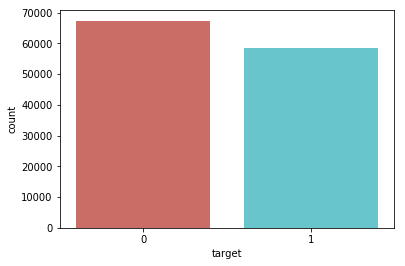

In [199]:
sns.countplot(x='target',data=data, palette='hls')
plt.show()

Identifying relationshipes between Y and X

In [200]:
data.groupby('target').mean()

duration     src_bytes     dst_bytes      land  wrong_fragment  \
target                                                                     
0       168.587396  13133.279331   4329.685223  0.000104        0.000000   
1       423.320689  82820.141327  37524.482159  0.000307        0.048746   

          urgent       hot  num_failed_logins  logged_in  num_compromised  \
target                                                                      
0       0.000148  0.230655           0.001381   0.710646         0.507076   
1       0.000068  0.174262           0.001040   0.034027         0.017568   

          ...      dst_host_srv_count  dst_host_same_srv_rate  \
target    ...                                                   
0         ...              190.285761                0.811875   
1         ...               29.929081                0.187417   

        dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
target                                                        
0                     0.040134                     0.121726   
1                     0.132131                     0.178993   

        dst_host_srv_diff_host_rate  dst_host_serror_rate  \
target                                                      
0                          0.025996              0.013930   
1                          0.040062              0.595177   

        dst_host_srv_serror_rate  dst_host_rerror_rate  \
target                                                   
0                       0.006116              0.046589   
1                       0.591329              0.201810   

        dst_host_srv_rerror_rate  last_flag  
target                                       
0                       0.044698   20.31592  
1                       0.207008   18.57155  

[2 rows x 39 columns]

In [201]:
nominal_vars = ['protocol_type', 'service', 'flag']
binary_vars = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
target = ['target']
numeric = data.columns.difference(nominal_vars + binary_vars + target)

In [202]:
categorical = nominal_vars + binary_vars + target

In [203]:
data_num = data[numeric]
data_cat = data[categorical]

#### Outlier Treatment

In [204]:
def outlierCapping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

#### Missing value Treatment

In [205]:
def missingImputation(x):
    x = x.fillna(x.mean())
    return x
def missingImputationCat(x):
    x = x.fillna(x.mode())
    return x

In [206]:
data_num = data_num.apply(lambda x: outlierCapping(x))

In [207]:
data_num = data_num.apply(lambda x: missingImputation(x))
data_cat = data_cat.apply(lambda x: missingImputationCat(x.astype('str')))

In [208]:
data[numeric].describe()

count  diff_srv_rate     dst_bytes  dst_host_count  \
count  125973.000000  125973.000000  1.259730e+05   125973.000000   
mean       84.107555       0.063053  1.977911e+04      182.148945   
std       114.508607       0.180314  4.021269e+06       99.206213   
min         0.000000       0.000000  0.000000e+00        0.000000   
25%         2.000000       0.000000  0.000000e+00       82.000000   
50%        14.000000       0.000000  0.000000e+00      255.000000   
75%       143.000000       0.060000  5.160000e+02      255.000000   
max       511.000000       1.000000  1.309937e+09      255.000000   

       dst_host_diff_srv_rate  dst_host_rerror_rate  \
count           125973.000000         125973.000000   
mean                 0.082951              0.118832   
std                  0.188922              0.306557   
min                  0.000000              0.000000   
25%                  0.000000              0.000000   
50%                  0.020000              0.000000   
75%                  0.070000              0.000000   
max                  1.000000              1.000000   

       dst_host_same_src_port_rate  dst_host_same_srv_rate  \
count                125973.000000           125973.000000   
mean                      0.148379                0.521242   
std                       0.308997                0.448949   
min                       0.000000                0.000000   
25%                       0.000000                0.050000   
50%                       0.000000                0.510000   
75%                       0.060000                1.000000   
max                       1.000000                1.000000   

       dst_host_serror_rate  dst_host_srv_count       ...        \
count         125973.000000       125973.000000       ...         
mean               0.284452          115.653005       ...         
std                0.444784          110.702741       ...         
min                0.000000            0.000000       ...         
25%                0.000000           10.000000       ...         
50%                0.000000           63.000000       ...         
75%                1.000000          255.000000       ...         
max                1.000000          255.000000       ...         

         rerror_rate  same_srv_rate    serror_rate     src_bytes  \
count  125973.000000  125973.000000  125973.000000  1.259730e+05   
mean        0.119958       0.660928       0.284485  4.556674e+04   
std         0.320436       0.439623       0.446456  5.870331e+06   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%         0.000000       0.090000       0.000000  0.000000e+00   
50%         0.000000       1.000000       0.000000  4.400000e+01   
75%         0.000000       1.000000       1.000000  2.760000e+02   
max         1.000000       1.000000       1.000000  1.379964e+09   

           srv_count  srv_diff_host_rate  srv_rerror_rate  srv_serror_rate  \
count  125973.000000       125973.000000    125973.000000    125973.000000   
mean       27.737888            0.097322         0.121183         0.282485   
std        72.635840            0.259830         0.323647         0.447022   
min         0.000000            0.000000         0.000000         0.000000   
25%         2.000000            0.000000         0.000000         0.000000   
50%         8.000000            0.000000         0.000000         0.000000   
75%        18.000000            0.000000         0.000000         1.000000   
max       511.000000            1.000000         1.000000         1.000000   

              urgent  wrong_fragment  
count  125973.000000   125973.000000  
mean        0.000111        0.022687  
std         0.014366        0.253530  
min         0.000000        0.000000  
25%         0.000000        0.000000  
50%         0.000000        0.000000  
75%         0.000000        0.000000  
max         3.000000        3.000000  

[8 rows x 33 columns]

In [209]:
data_num.describe()

count  diff_srv_rate      dst_bytes  dst_host_count  \
count  125973.000000  125973.000000  125973.000000   125973.000000   
mean       84.107658       0.063053    1342.118549      182.148968   
std       114.508532       0.180314    3804.294003       99.206169   
min         1.000000       0.000000       0.000000        1.000000   
25%         2.000000       0.000000       0.000000       82.000000   
50%        14.000000       0.000000       0.000000      255.000000   
75%       143.000000       0.060000     516.000000      255.000000   
max       511.000000       1.000000   25519.000000      255.000000   

       dst_host_diff_srv_rate  dst_host_rerror_rate  \
count           125973.000000         125973.000000   
mean                 0.082951              0.118832   
std                  0.188922              0.306557   
min                  0.000000              0.000000   
25%                  0.000000              0.000000   
50%                  0.020000              0.000000   
75%                  0.070000              0.000000   
max                  1.000000              1.000000   

       dst_host_same_src_port_rate  dst_host_same_srv_rate  \
count                125973.000000           125973.000000   
mean                      0.148379                0.521242   
std                       0.308997                0.448949   
min                       0.000000                0.000000   
25%                       0.000000                0.050000   
50%                       0.000000                0.510000   
75%                       0.060000                1.000000   
max                       1.000000                1.000000   

       dst_host_serror_rate  dst_host_srv_count       ...        \
count         125973.000000       125973.000000       ...         
mean               0.284452          115.653029       ...         
std                0.444784          110.702716       ...         
min                0.000000            1.000000       ...         
25%                0.000000           10.000000       ...         
50%                0.000000           63.000000       ...         
75%                1.000000          255.000000       ...         
max                1.000000          255.000000       ...         

         rerror_rate  same_srv_rate    serror_rate      src_bytes  \
count  125973.000000  125973.000000  125973.000000  125973.000000   
mean        0.119958       0.660928       0.284485    1029.498123   
std         0.320436       0.439623       0.446456    6137.901578   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.090000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000      44.000000   
75%         0.000000       1.000000       1.000000     276.000000   
max         1.000000       1.000000       1.000000   54540.000000   

           srv_count  srv_diff_host_rate  srv_rerror_rate  srv_serror_rate  \
count  125973.000000       125973.000000    125973.000000    125973.000000   
mean       27.553158            0.097322         0.121183         0.282485   
std        71.420190            0.259830         0.323647         0.447022   
min         1.000000            0.000000         0.000000         0.000000   
25%         2.000000            0.000000         0.000000         0.000000   
50%         8.000000            0.000000         0.000000         0.000000   
75%        18.000000            0.000000         0.000000         1.000000   
max       492.000000            1.000000         1.000000         1.000000   

         urgent  wrong_fragment  
count  125973.0        125973.0  
mean        0.0             0.0  
std         0.0             0.0  
min         0.0             0.0  
25%         0.0             0.0  
50%         0.0             0.0  
75%         0.0             0.0  
max         0.0             0.0  

[8 rows x 33 columns]

#### Dummy variable creation

In [210]:
def createDummyVariables(df,col):
    df_dummy = pd.get_dummies(data=df[col],drop_first=True,prefix=col)
    df = pd.concat([df,df_dummy],axis=1)
    df.drop(col,axis=1,inplace=True)
    return df

In [211]:
data_cat_new = data_cat
for feature in data_cat.columns.difference(['target']):
    data_cat_new = createDummyVariables(data_cat_new,feature)
data_cat_new.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 89 columns):
target                 125973 non-null object
flag_REJ               125973 non-null uint8
flag_RSTO              125973 non-null uint8
flag_RSTOS0            125973 non-null uint8
flag_RSTR              125973 non-null uint8
flag_S0                125973 non-null uint8
flag_S1                125973 non-null uint8
flag_S2                125973 non-null uint8
flag_S3                125973 non-null uint8
flag_SF                125973 non-null uint8
flag_SH                125973 non-null uint8
is_guest_login_1       125973 non-null uint8
is_host_login_1        125973 non-null uint8
land_1                 125973 non-null uint8
logged_in_1            125973 non-null uint8
protocol_type_tcp      125973 non-null uint8
protocol_type_udp      125973 non-null uint8
root_shell_1           125973 non-null uint8
service_X11            125973 non-null uint8
service_Z39_50         125973 non

In [212]:
data_cat_new.head()

target  flag_REJ  flag_RSTO  flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  \
0      0         0          0            0          0        0        0   
1      0         0          0            0          0        0        0   
2      1         0          0            0          0        1        0   
3      0         0          0            0          0        0        0   
4      0         0          0            0          0        0        0   

   flag_S2  flag_S3  flag_SF       ...        service_tim_i  service_time  \
0        0        0        1       ...                    0             0   
1        0        0        1       ...                    0             0   
2        0        0        0       ...                    0             0   
3        0        0        1       ...                    0             0   
4        0        0        1       ...                    0             0   

   service_urh_i  service_urp_i  service_uucp  service_uucp_path  \
0              0              0             0                  0   
1              0              0             0                  0   
2              0              0             0                  0   
3              0              0             0                  0   
4              0              0             0                  0   

   service_vmnet  service_whois  su_attempted_1  su_attempted_2  
0              0              0               0               0  
1              0              0               0               0  
2              0              0               0               0  
3              0              0               0               0  
4              0              0               0               0  

[5 rows x 89 columns]

#### Feature Selection

In [213]:
temp = data_num.describe().T
temp[temp['std'] == 0]

count  mean  std  min  25%  50%  75%  max
num_access_files    125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_failed_logins   125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_file_creations  125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_outbound_cmds   125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_root            125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_shells          125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
urgent              125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
wrong_fragment      125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [214]:
data_num.drop(columns=['num_access_files',
                      'num_failed_logins',
                      'num_file_creations',
                      'num_outbound_cmds',
                      'num_root',
                      'num_shells',
                      'urgent',
                      'wrong_fragment'], axis=1, inplace=True)

Correlation matrix

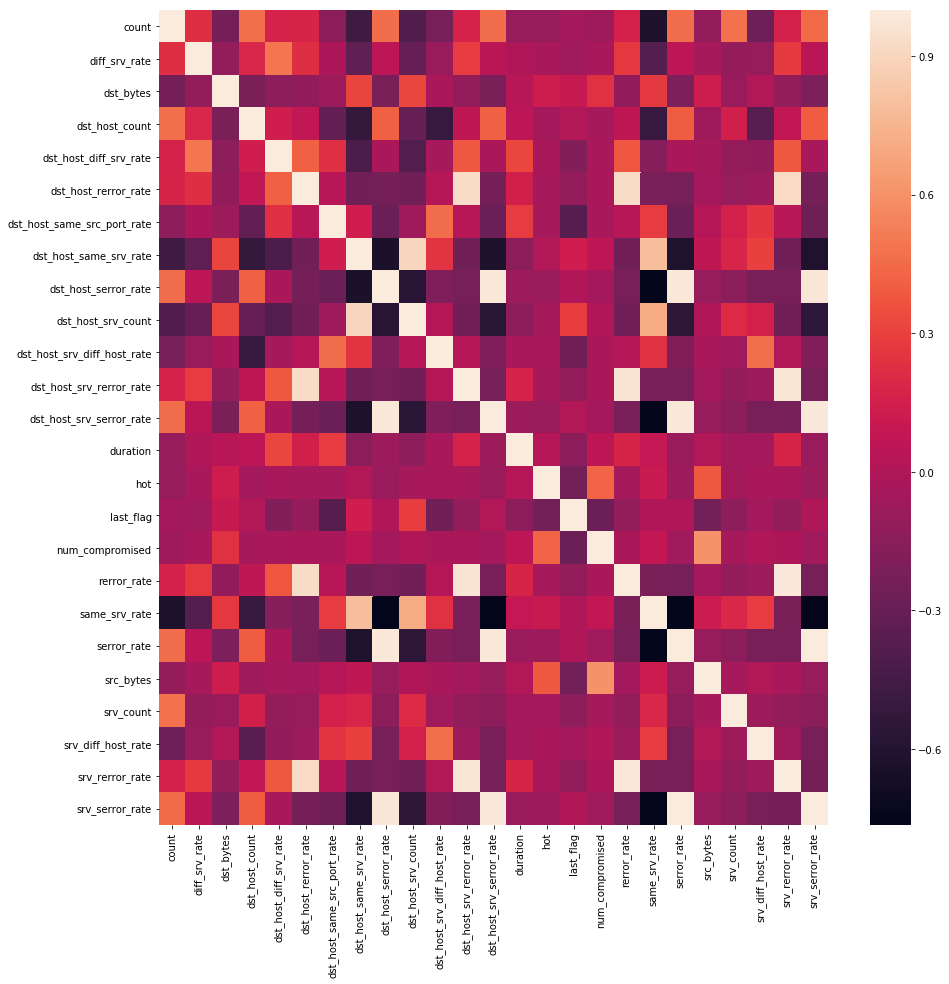

In [215]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data_num.corr())
plt.show()

In [216]:
corrm = data_num.corr()
corrm.to_csv('corrm.csv')

Drop the variables with less correlation with the target

In [217]:
data_num.drop(columns=['dst_host_rerror_rate',
                      'dst_host_serror_rate',
                      'dst_host_srv_rerror_rate',
                      'dst_host_srv_serror_rate',
                      'dst_host_same_srv_rate',
                      'srv_rerror_rate',
                      'srv_serror_rate'], inplace=True, axis=1)

#### WOE or log odds

In [218]:
data_new = pd.concat([data_num, data_cat_new], axis=1)
data_new.target = pd.to_numeric(data_new.target)
data_new.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 107 columns):
count                          125973 non-null float64
diff_srv_rate                  125973 non-null float64
dst_bytes                      125973 non-null float64
dst_host_count                 125973 non-null float64
dst_host_diff_srv_rate         125973 non-null float64
dst_host_same_src_port_rate    125973 non-null float64
dst_host_srv_count             125973 non-null float64
dst_host_srv_diff_host_rate    125973 non-null float64
duration                       125973 non-null float64
hot                            125973 non-null float64
last_flag                      125973 non-null float64
num_compromised                125973 non-null float64
rerror_rate                    125973 non-null float64
same_srv_rate                  125973 non-null float64
serror_rate                    125973 non-null float64
src_bytes                      125973 non-null float64
srv_coun

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


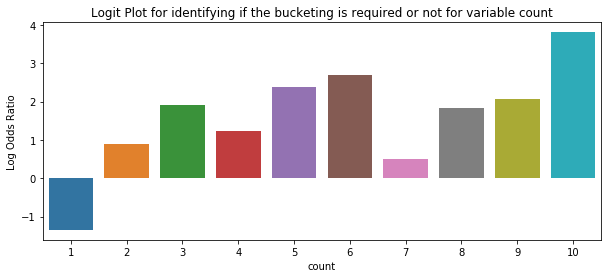

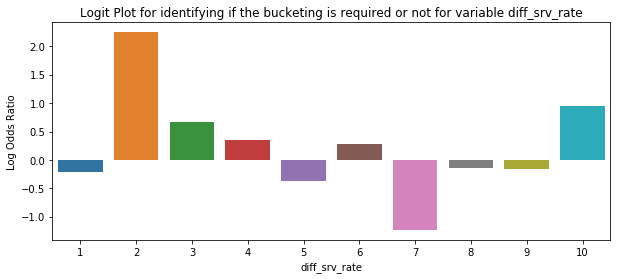

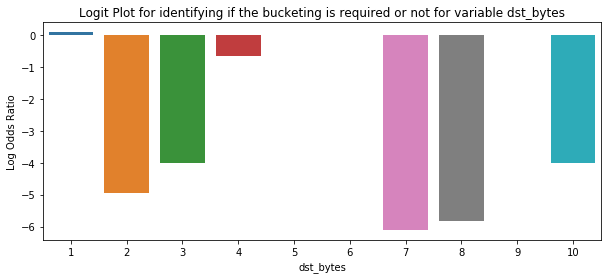

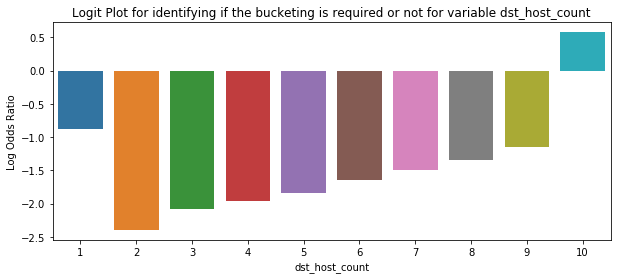

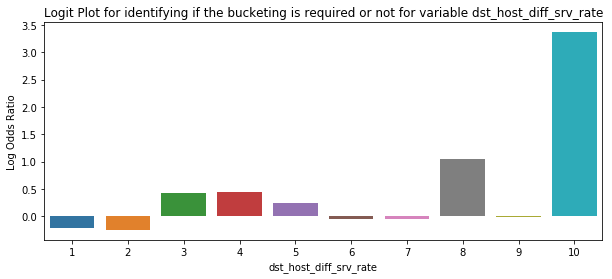

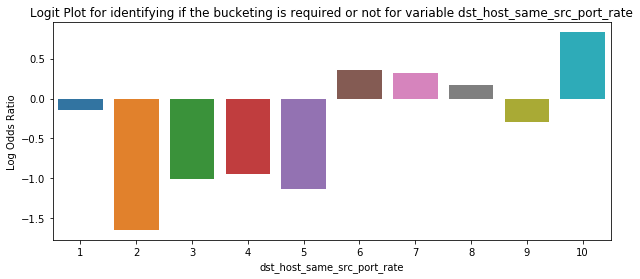

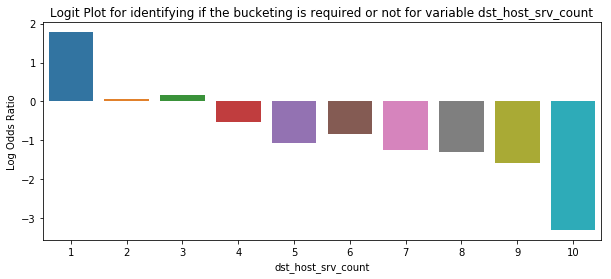

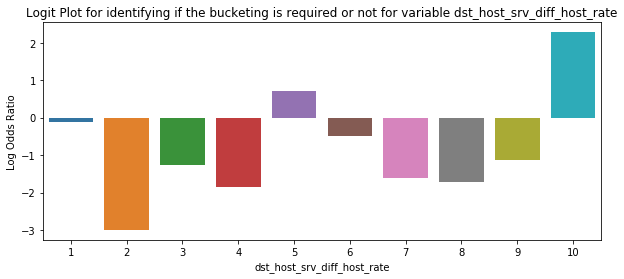

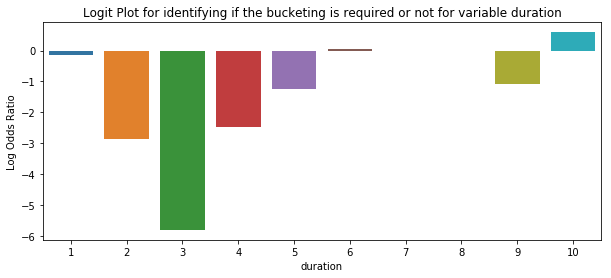

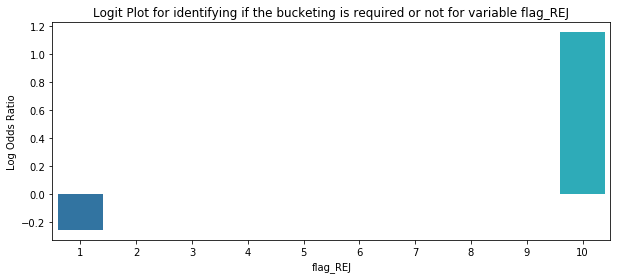

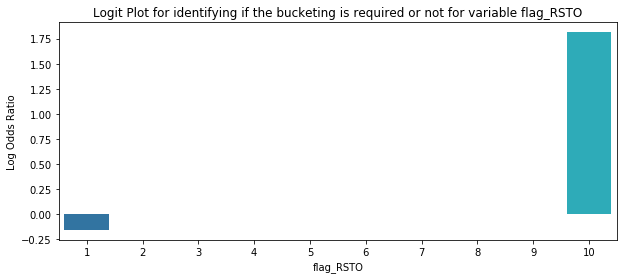

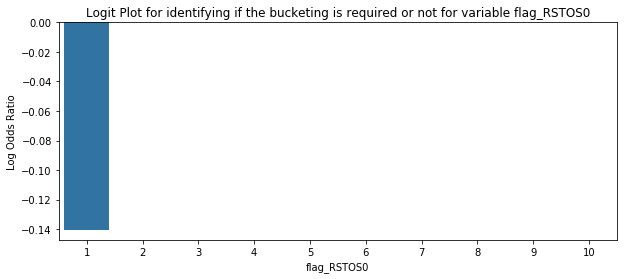

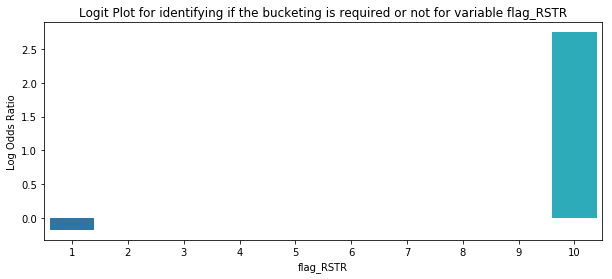

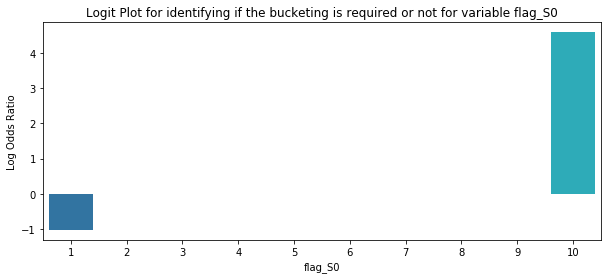

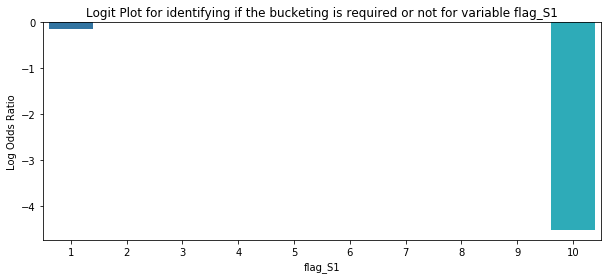

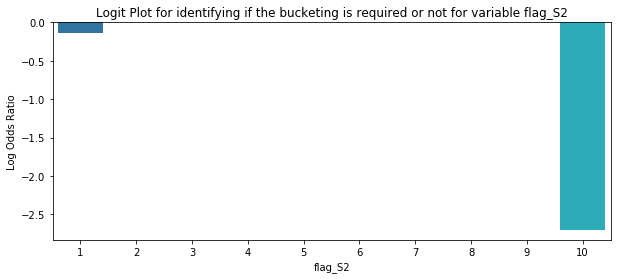

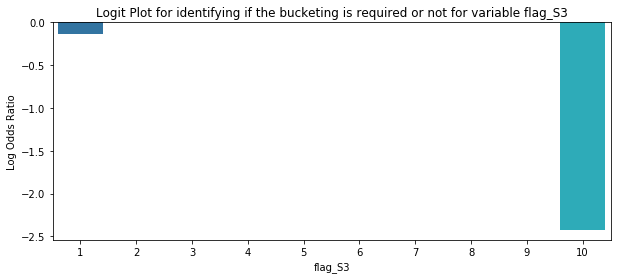

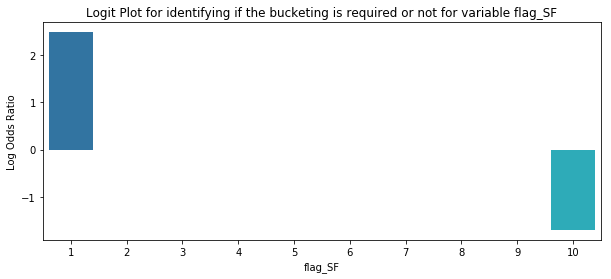

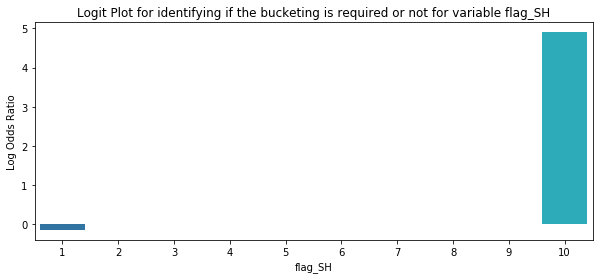

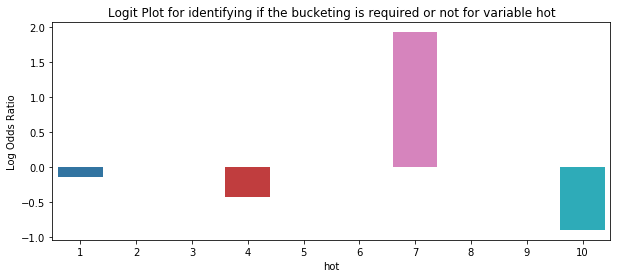

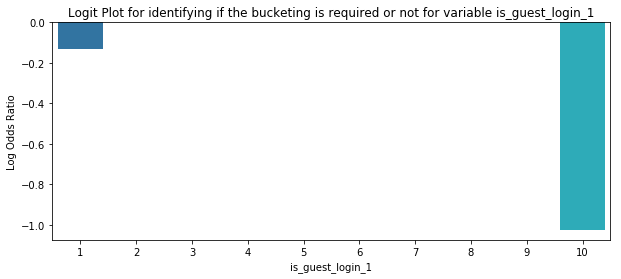

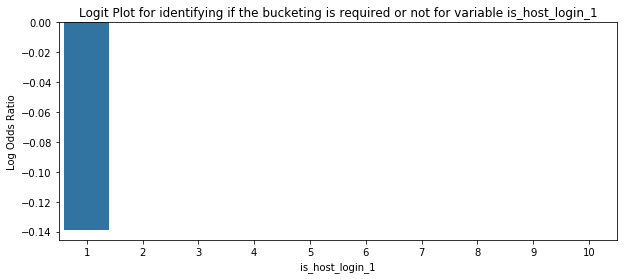

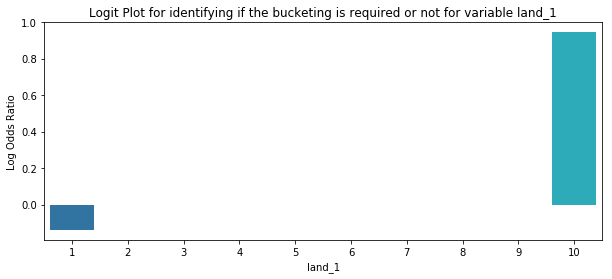

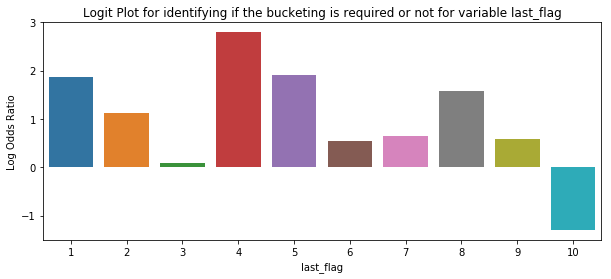

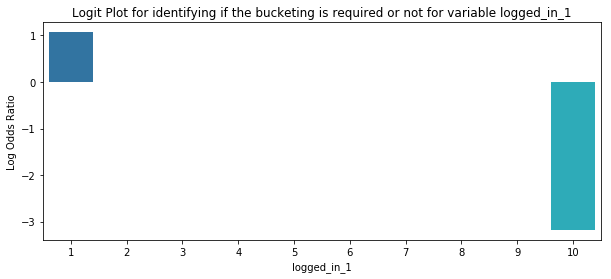

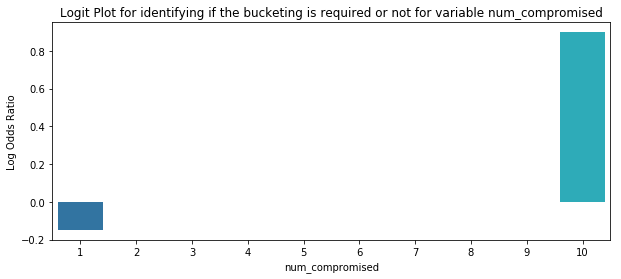

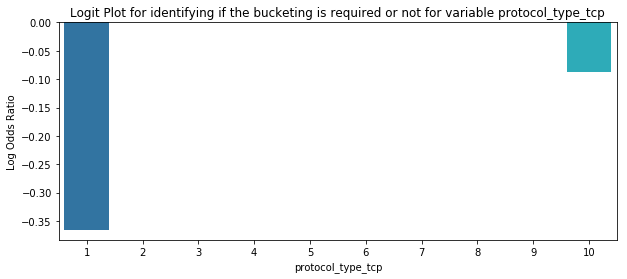

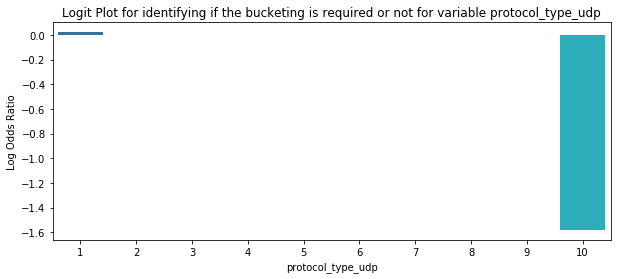

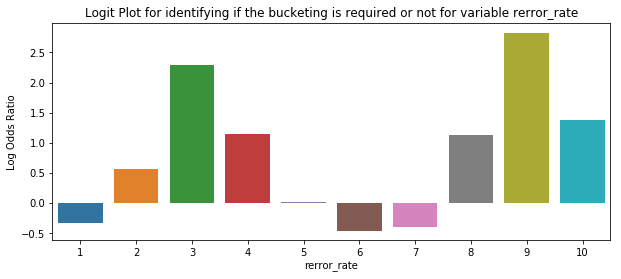

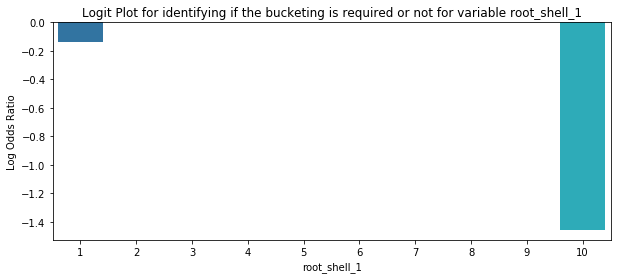

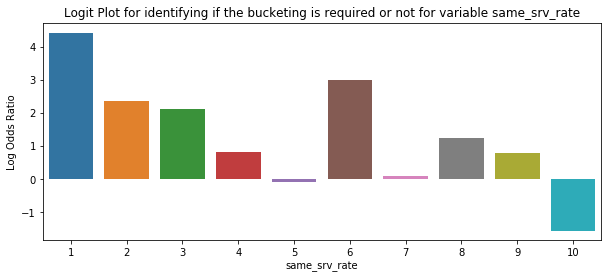

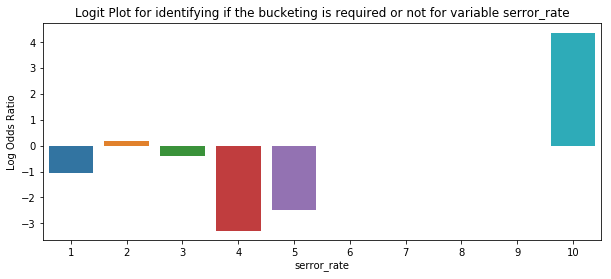

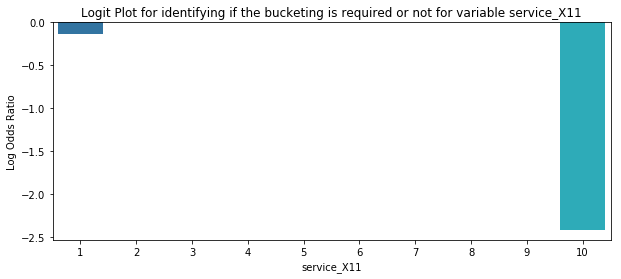

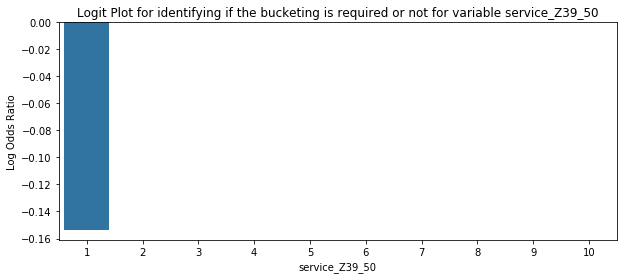

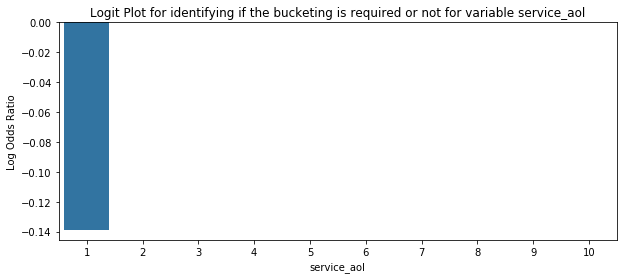

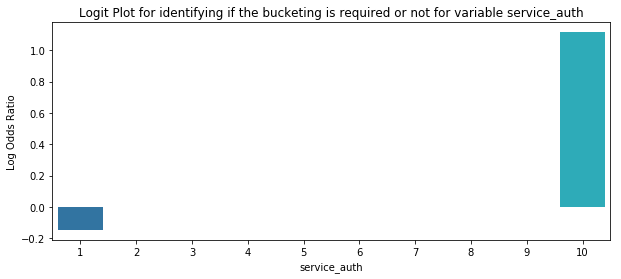

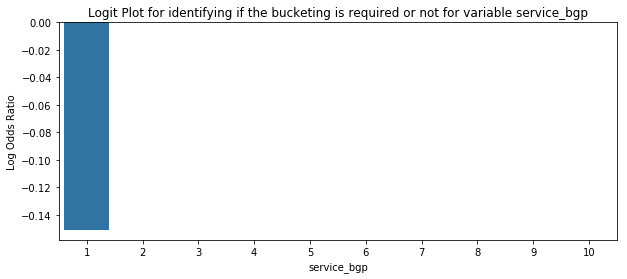

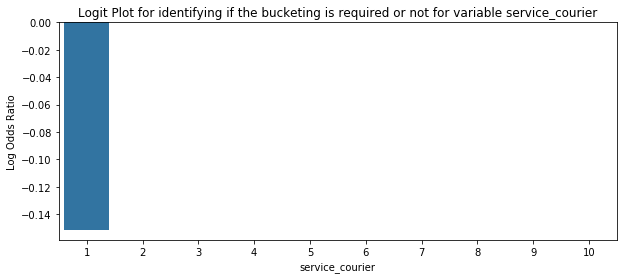

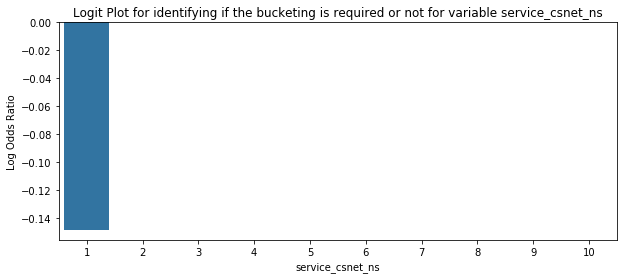

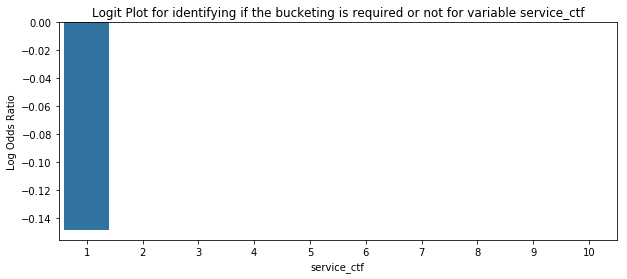

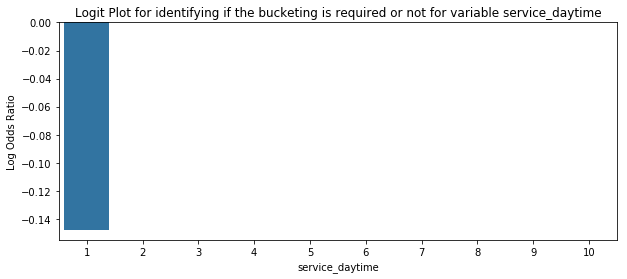

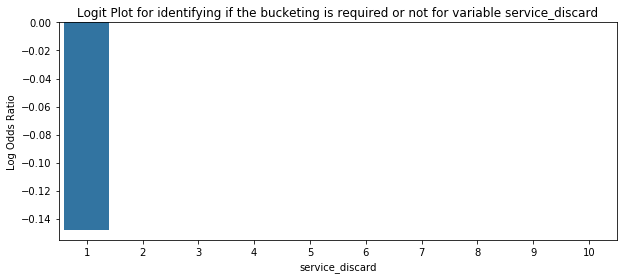

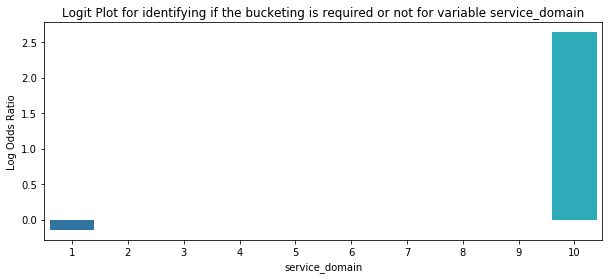

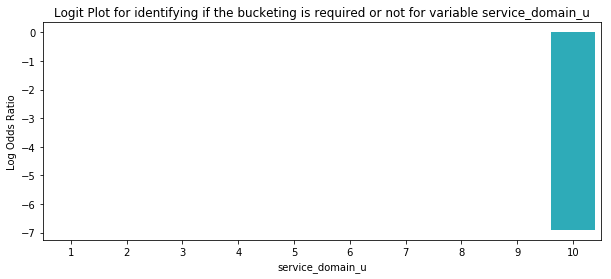

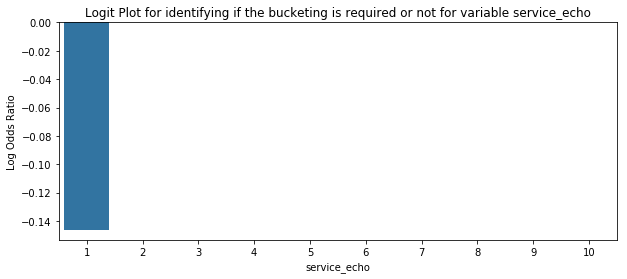

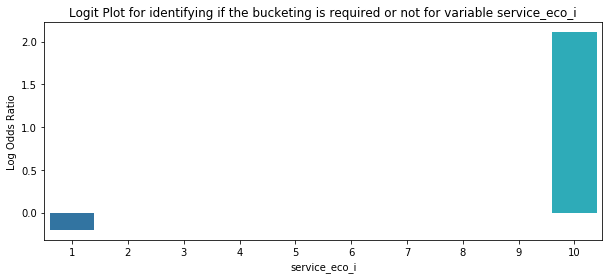

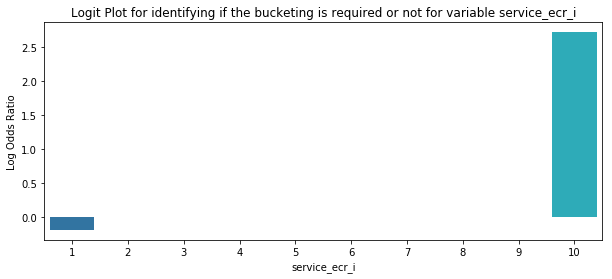

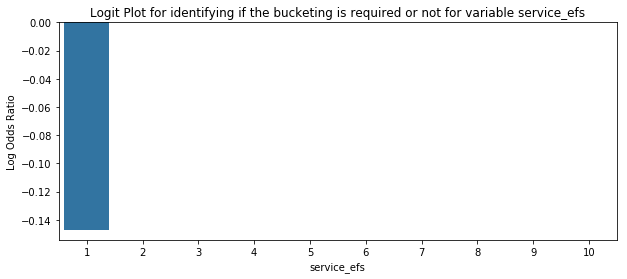

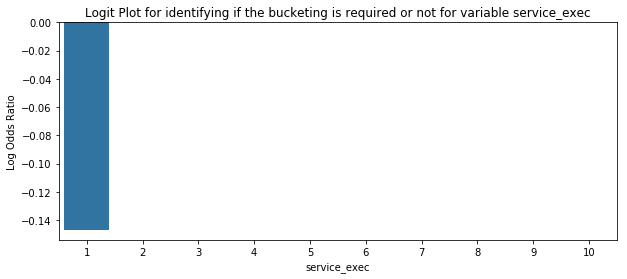

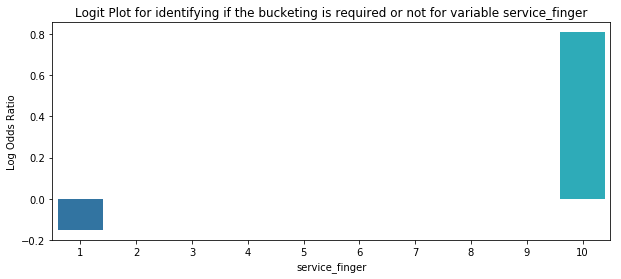

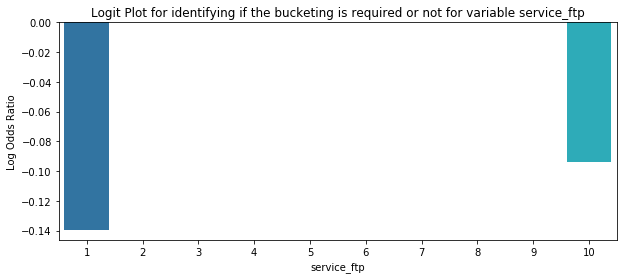

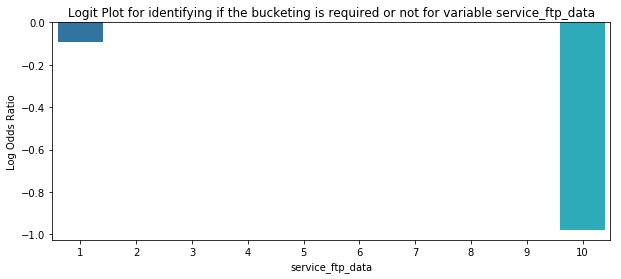

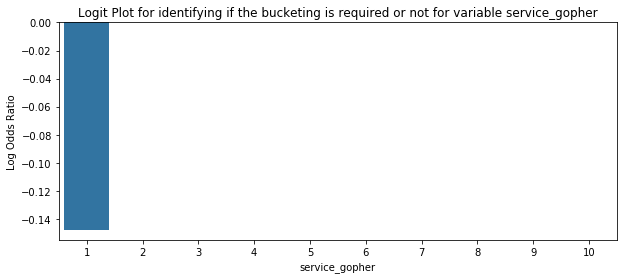

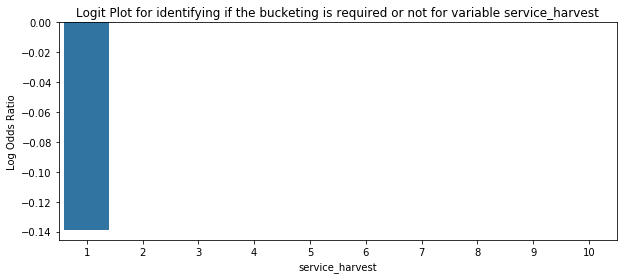

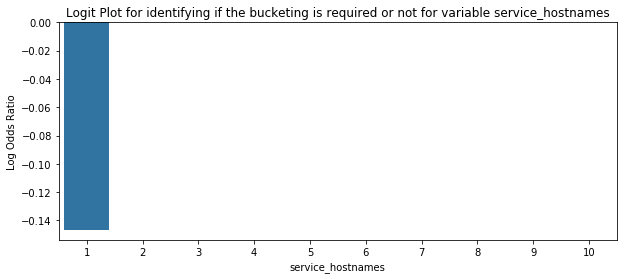

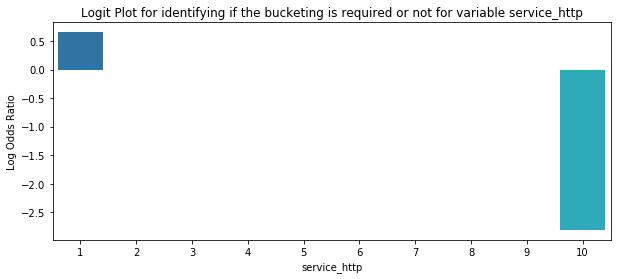

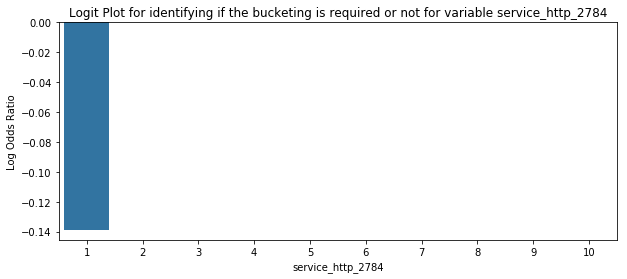

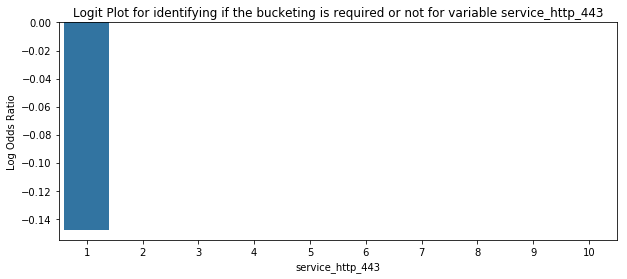

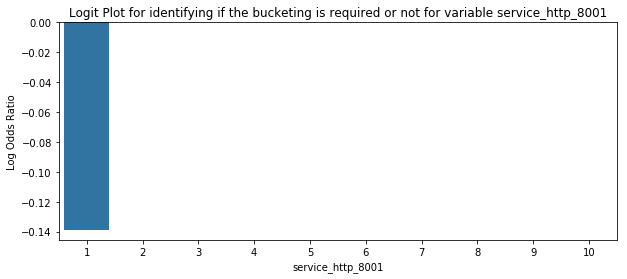

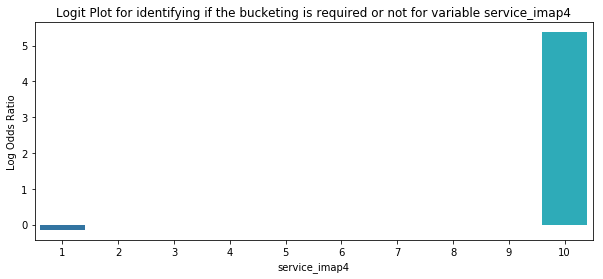

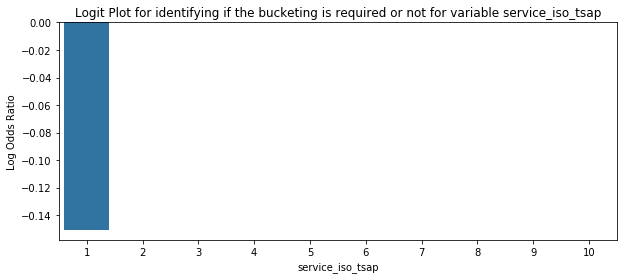

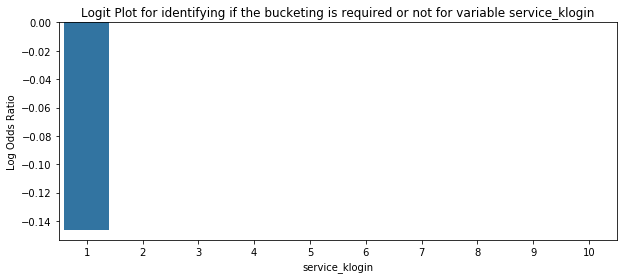

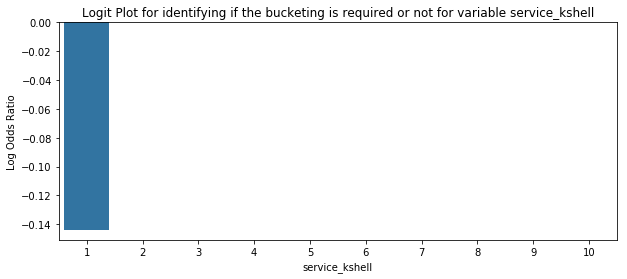

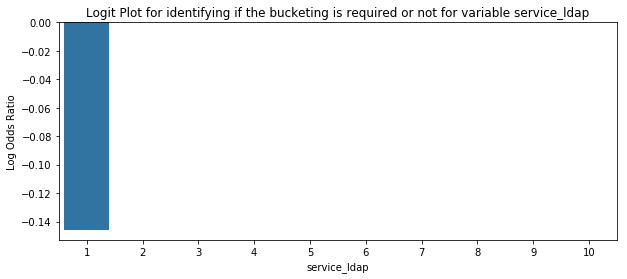

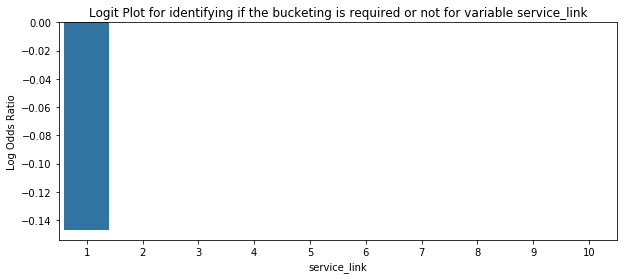

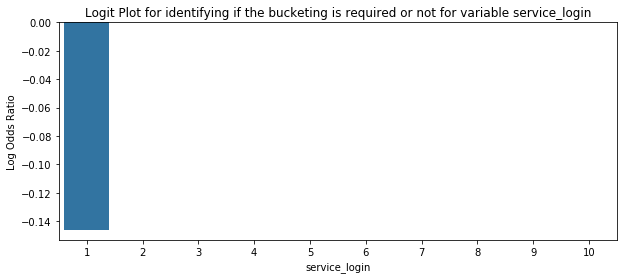

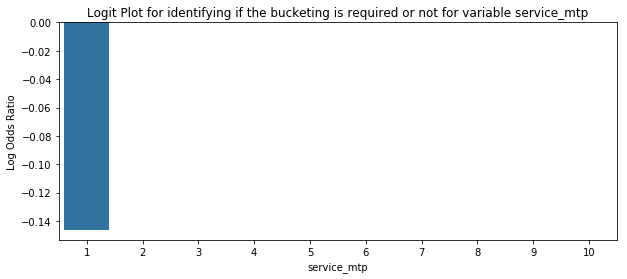

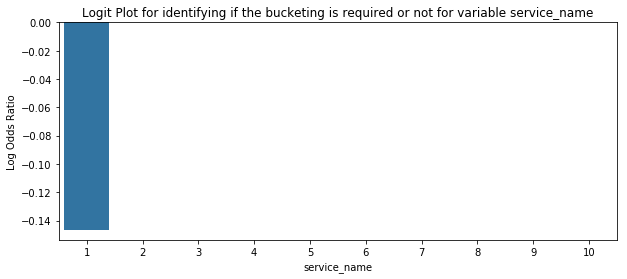

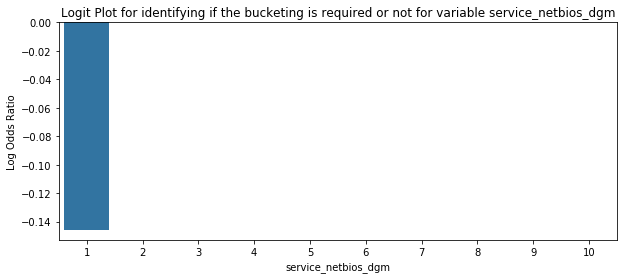

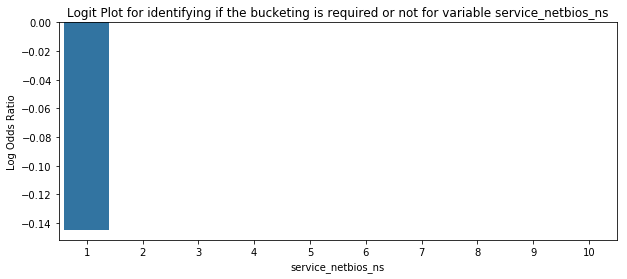

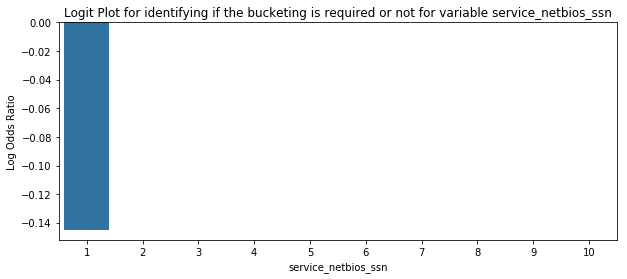

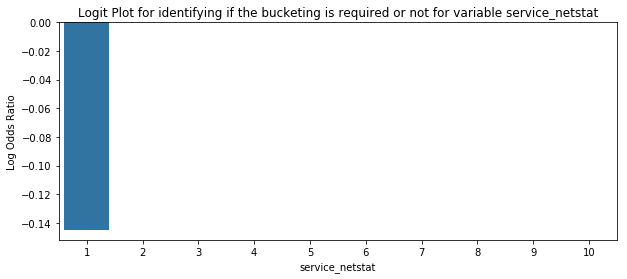

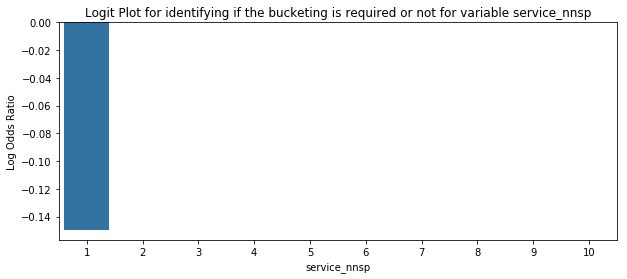

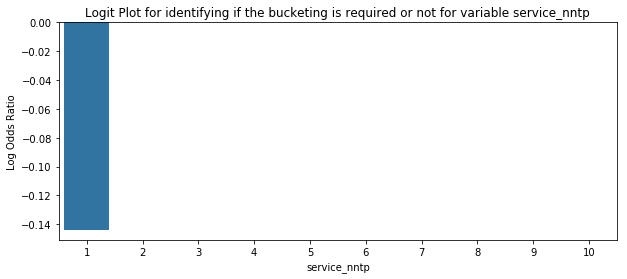

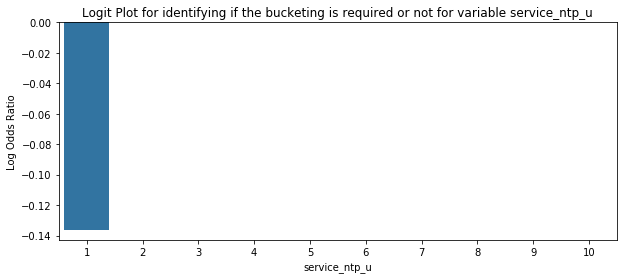

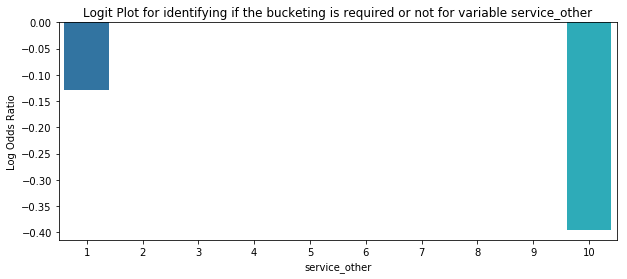

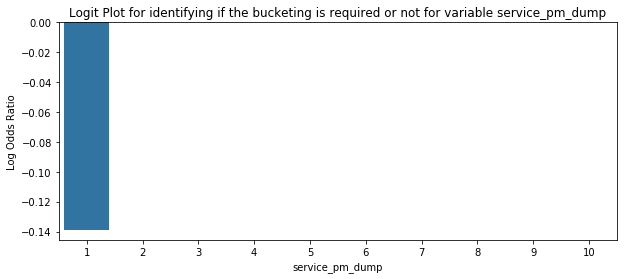

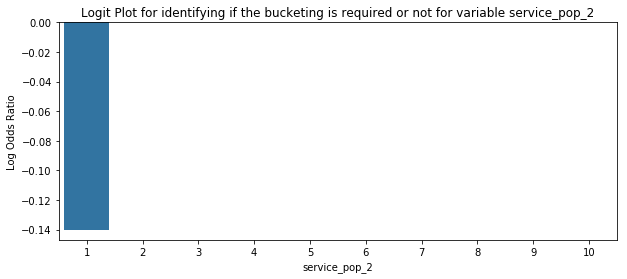

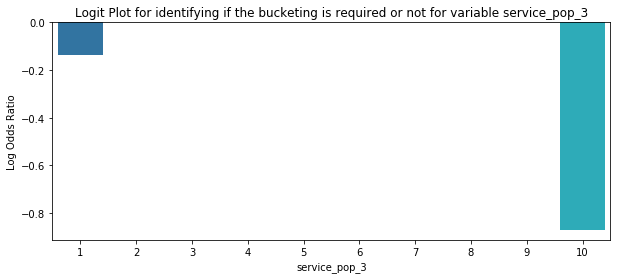

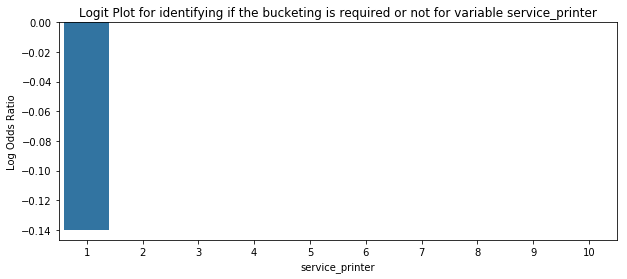

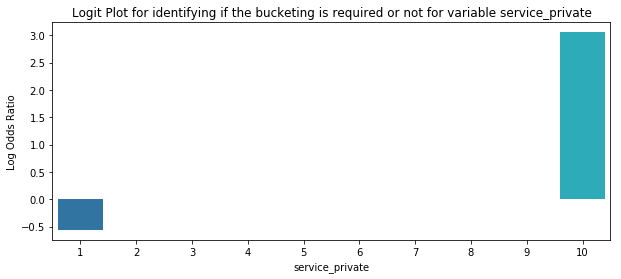

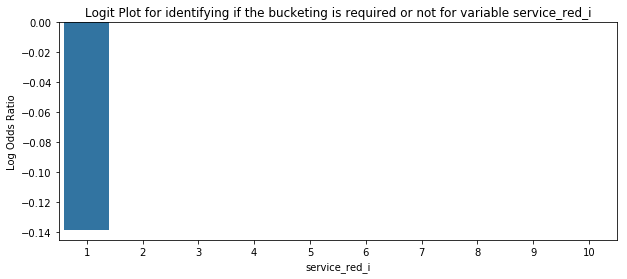

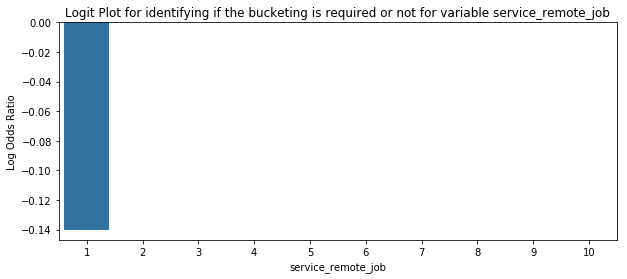

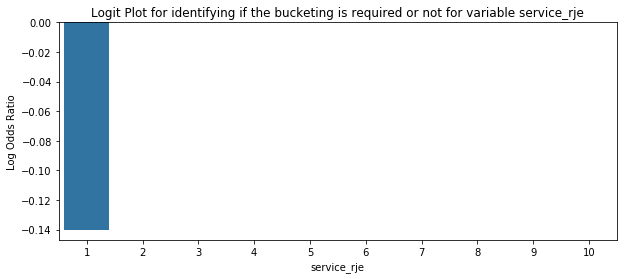

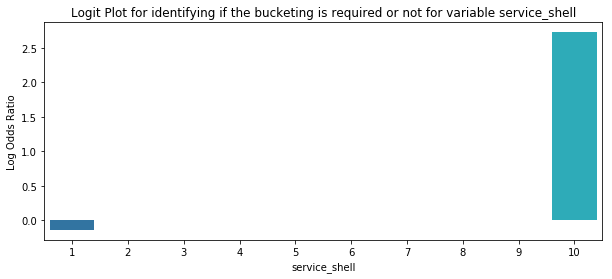

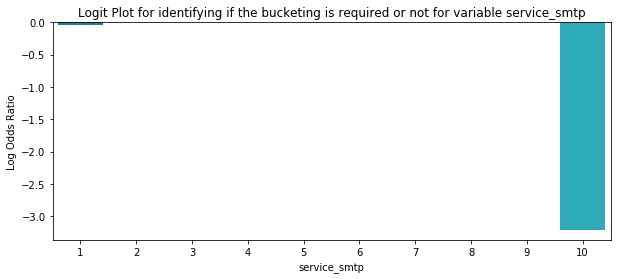

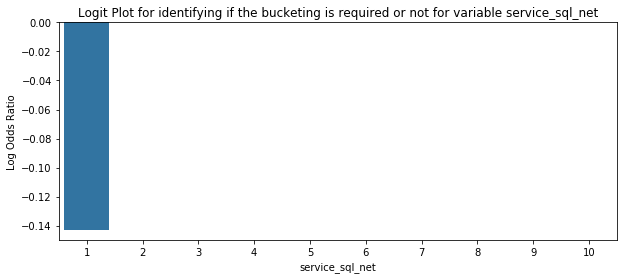

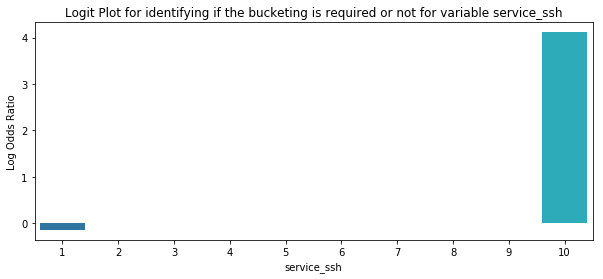

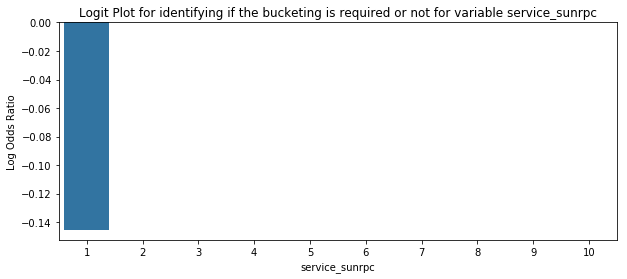

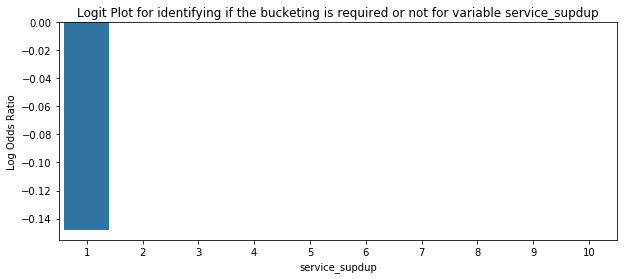

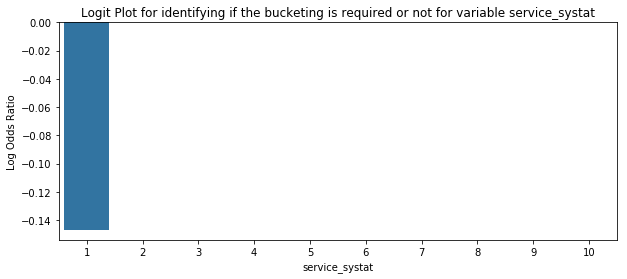

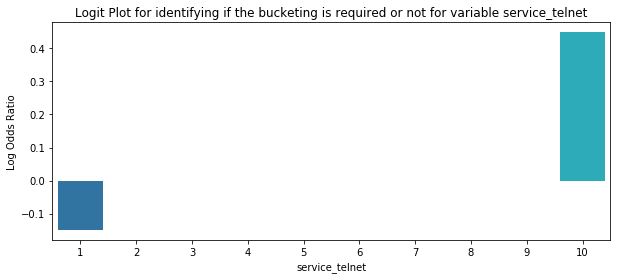

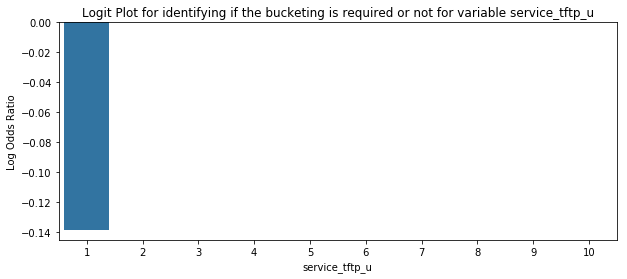

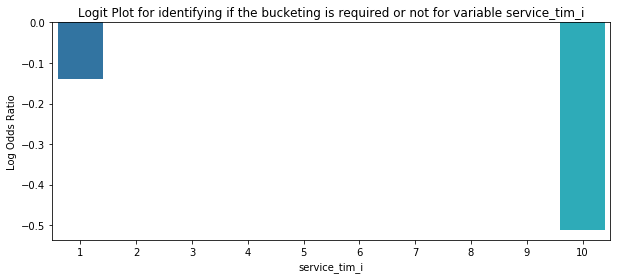

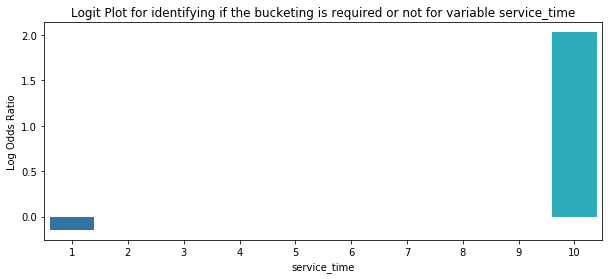

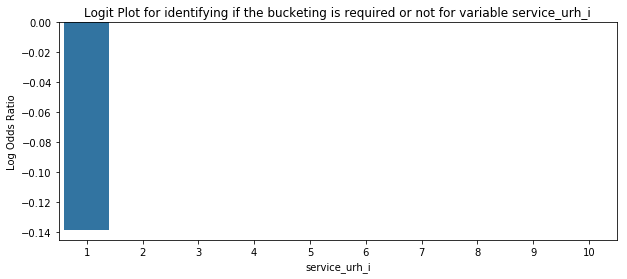

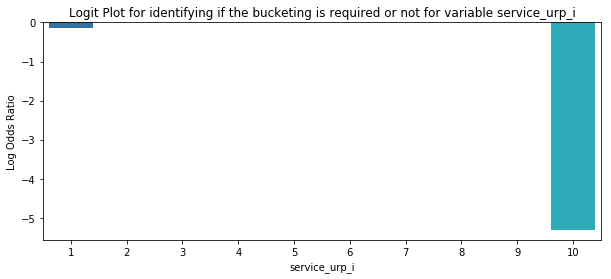

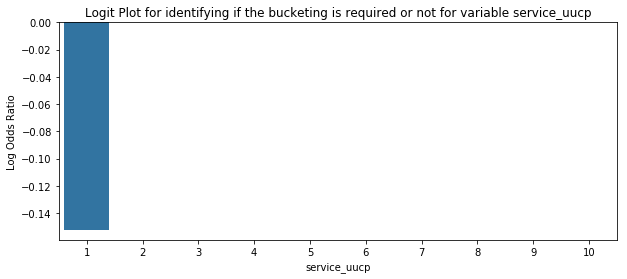

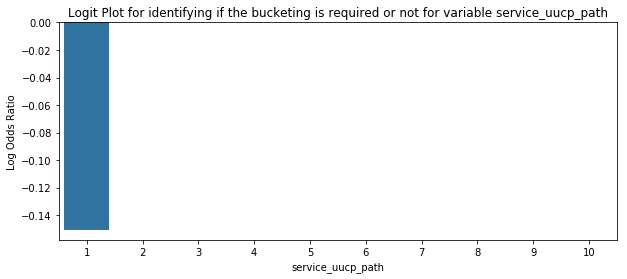

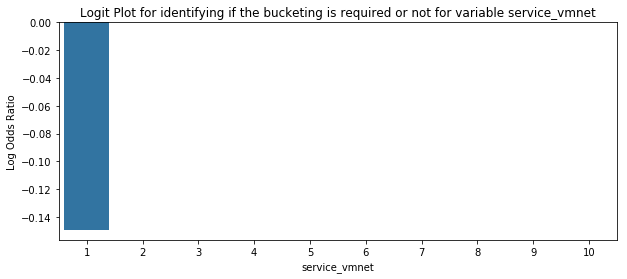

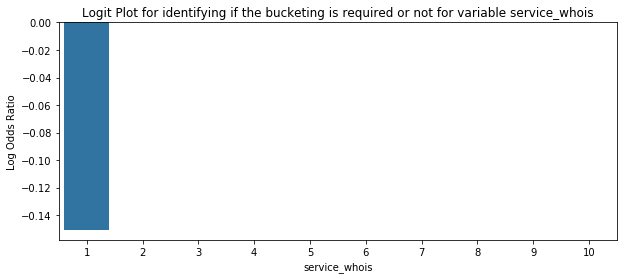

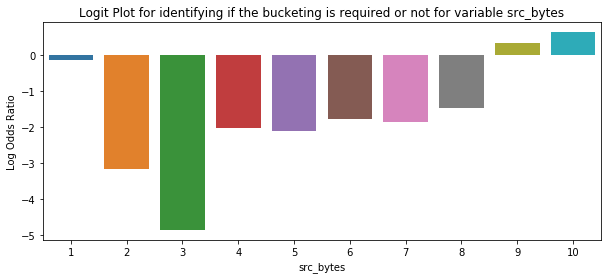

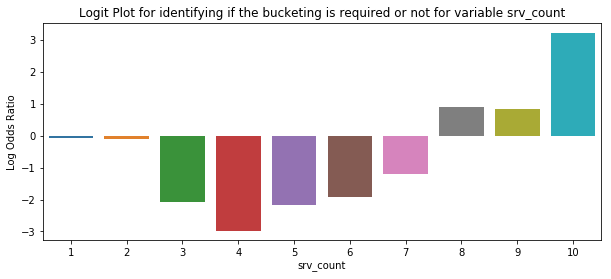

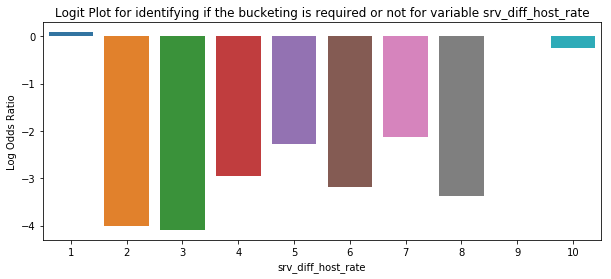

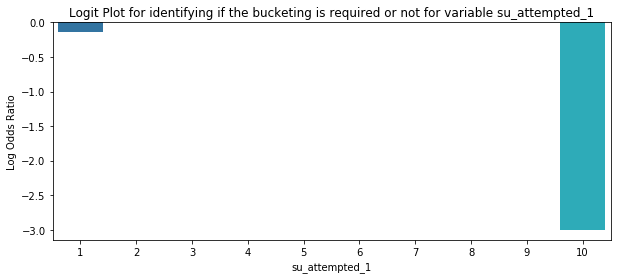

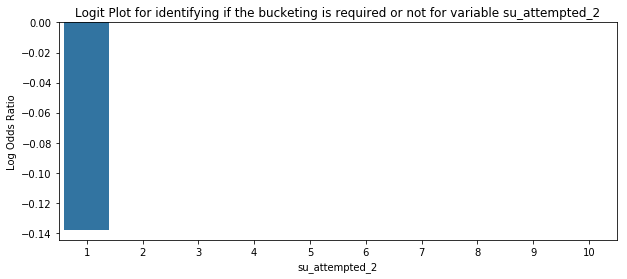

In [219]:
# bp = PdfPages('WOE Plots.pdf')

for feature in data_new.columns.difference(['target']):
    binned = pd.cut(data_new[feature], bins=10, labels=list(range(1,11)))
    #binned = binned.dropna()
    odds = data_new.groupby(binned)['target'].sum() / (data_new.groupby(binned)['target'].count()-data_new.groupby(binned)['target'].sum())
    log_odds = np.log(odds)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=log_odds.index,y=log_odds)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(feature))
#     bp.savefig(fig)

# bp.close()

In [220]:
# Features from WOE plots:
WOE_list = ['count',
           'diff_srv_rate',
           'dst_bytes',
           'dst_host_count',
           'dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate',
           'dst_host_srv_count',
           'dst_host_srv_diff_host_rate',
           'duration',
           'flag_REJ',
           'flag_RSTO',
           'last_flag',
           'rerror_rate',
           'same_srv_rate',
           'serror_rate',
           'src_bytes',
           'srv_count']

In [222]:
data_new.columns

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'duration', 'hot',
       ...
       'service_tim_i', 'service_time', 'service_urh_i', 'service_urp_i',
       'service_uucp', 'service_uucp_path', 'service_vmnet', 'service_whois',
       'su_attempted_1', 'su_attempted_2'],
      dtype='object', length=107)

#### SomersD

In [223]:
somersd_df = pd.DataFrame()
for feature in data_new.columns.difference(['target']):
    print(feature)
    logreg = sm.logit(formula=str('target ~ ')+str(feature), data=data_new)
    result = logreg.fit(maxiter=10)
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['score']
    somers_d = 2 * metrics.roc_auc_score(y_score=y_score, y_true=data_new.target) - 1
    temp = pd.DataFrame([feature, somers_d]).T
    temp.columns = ['Feature','SomersD']
    somersd_df = pd.concat([somersd_df,temp],axis=0)

count
Optimization terminated successfully.
         Current function value: 0.474707
         Iterations 7
diff_srv_rate
Optimization terminated successfully.
         Current function value: 0.666611
         Iterations 6
dst_bytes
Optimization terminated successfully.
         Current function value: 0.594466
         Iterations 8
dst_host_count
Optimization terminated successfully.
         Current function value: 0.615406
         Iterations 5
dst_host_diff_srv_rate
Optimization terminated successfully.
         Current function value: 0.656414
         Iterations 6
dst_host_same_src_port_rate
Optimization terminated successfully.
         Current function value: 0.686483
         Iterations 4
dst_host_srv_count
Optimization terminated successfully.
         Current function value: 0.380618
         Iterations 7
dst_host_srv_diff_host_rate
Optimization terminated successfully.
         Current function value: 0.689234
         Iterations 4
duration
Optimization terminated successf

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.433831
         Iterations 9
flag_S1
Optimization terminated successfully.
         Current function value: 0.689106
         Iterations 8
flag_S2
Optimization terminated successfully.
         Current function value: 0.690350
         Iterations 7
flag_S3
Optimization terminated successfully.
         Current function value: 0.690615
         Iterations 6
flag_SF
Optimization terminated successfully.
         Current function value: 0.366053
         Iterations 6
flag_SH
Optimization terminated successfully.
         Current function value: 0.689201
         Iterations 9
hot
Optimization terminated successfully.
         Current function value: 0.690731
         Iterations 3
is_guest_login_1
Optimization terminated successfully.
         Current function value: 0.689943
         Iterations 5
is_host_login_1
         Current function value: 0.690748
         Iterations: 10
land_1
Optimization terminated successful

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


last_flag
Optimization terminated successfully.
         Current function value: 0.593763
         Iterations 6
logged_in_1
Optimization terminated successfully.
         Current function value: 0.410201
         Iterations 7
num_compromised
Optimization terminated successfully.
         Current function value: 0.689482
         Iterations 5
protocol_type_tcp
Optimization terminated successfully.
         Current function value: 0.689334
         Iterations 4
protocol_type_udp
Optimization terminated successfully.
         Current function value: 0.664989
         Iterations 5
rerror_rate
Optimization terminated successfully.
         Current function value: 0.657051
         Iterations 5
root_shell_1
Optimization terminated successfully.
         Current function value: 0.690529
         Iterations 5
same_srv_rate
Optimization terminated successfully.
         Current function value: 0.358365
         Iterations 7
serror_rate
Optimization terminated successfully.
         Current func

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


service_auth
Optimization terminated successfully.
         Current function value: 0.689444
         Iterations 5
service_bgp
         Current function value: 0.686424
         Iterations: 10


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


service_courier
         Current function value: 0.686277
         Iterations: 10
service_csnet_ns
         Current function value: 0.687434
         Iterations: 10
service_ctf
         Current function value: 0.687324
         Iterations: 10
service_daytime


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.687580
         Iterations: 10
service_discard
         Current function value: 0.687477
         Iterations: 10
service_domain


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.688439
         Iterations 7
service_domain_u
         Current function value: 0.643951
         Iterations: 10
service_echo


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.688112
         Iterations: 10
service_eco_i
Optimization terminated successfully.
         Current function value: 0.675444
         Iterations 6
service_ecr_i
Optimization terminated successfully.
         Current function value: 0.677667
         Iterations 7
service_efs
         Current function value: 0.687800
         Iterations: 10
service_exec


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.687867
         Iterations: 10
service_finger
Optimization terminated successfully.
         Current function value: 0.689271
         Iterations 5
service_ftp
Optimization terminated successfully.
         Current function value: 0.690750
         Iterations 3
service_ftp_data
Optimization terminated successfully.
         Current function value: 0.686302
         Iterations 5
service_gopher
         Current function value: 0.687599
         Iterations: 10
service_harvest


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.690741
         Iterations: 10
service_hostnames
         Current function value: 0.687953
         Iterations: 10
service_http


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.506479
         Iterations 7
service_http_2784
         Current function value: 0.690747
         Iterations: 10
service_http_443


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.687525
         Iterations: 10
service_http_8001
         Current function value: 0.690741
         Iterations: 10
service_imap4


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.686965
         Iterations 9
service_iso_tsap
         Current function value: 0.686565
         Iterations: 10
service_klogin


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.688118
         Iterations: 10
service_kshell


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.688935
         Iterations: 10
service_ldap
         Current function value: 0.688258
         Iterations: 10


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


service_link
         Current function value: 0.687861
         Iterations: 10
service_login


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.688142
         Iterations: 10
service_mtp
         Current function value: 0.688081
         Iterations: 10
service_name


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.688008
         Iterations: 10
service_netbios_dgm
         Current function value: 0.688289
         Iterations: 10
service_netbios_ns


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.688642
         Iterations: 10
service_netbios_ssn
         Current function value: 0.688551
         Iterations: 10
service_netstat


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.688563
         Iterations: 10
service_nnsp
         Current function value: 0.686914
         Iterations: 10
service_nntp


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.688953
         Iterations: 10
service_ntp_u
         Current function value: 0.689917
         Iterations: 10
service_other
Optimization terminated successfully.
         Current function value: 0.690467
         Iterations 4


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


service_pm_dump
         Current function value: 0.690723
         Iterations: 10
service_pop_2


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.690280
         Iterations: 10
service_pop_3
Optimization terminated successfully.
         Current function value: 0.690627
         Iterations 5
service_printer
         Current function value: 0.690334
         Iterations: 10


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


service_private
Optimization terminated successfully.
         Current function value: 0.573117
         Iterations 7
service_red_i
         Current function value: 0.690714
         Iterations: 10
service_remote_job
         Current function value: 0.690280
         Iterations: 10
service_rje


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.690231
         Iterations: 10
service_shell
Optimization terminated successfully.
         Current function value: 0.690482
         Iterations 7
service_smtp
Optimization terminated successfully.
         Current function value: 0.662312
         Iterations 7

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



service_sql_net
         Current function value: 0.689264
         Iterations: 10
service_ssh
Optimization terminated successfully.
         Current function value: 0.689071
         Iterations 8


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


service_sunrpc
         Current function value: 0.688435
         Iterations: 10
service_supdup


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.687440
         Iterations: 10
service_systat
         Current function value: 0.687849
         Iterations: 10
service_telnet
Optimization terminated successfully.
         Current function value: 0.689950
         Iterations 4


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


service_tftp_u
         Current function value: 0.690738
         Iterations: 10
service_tim_i
Optimization terminated successfully.
         Current function value: 0.690752
         Iterations 4
service_time
Optimization terminated successfully.
         Current function value: 0.688722
         Iterations 6
service_urh_i
         Current function value: 0.690704
         Iterations: 10
service_urp_i


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.687897
         Iterations 9
service_uucp
         Current function value: 0.685996
         Iterations: 10
service_uucp_path


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.686553
         Iterations: 10
service_vmnet
         Current function value: 0.686994
         Iterations: 10
service_whois


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.686529
         Iterations: 10
src_bytes
Optimization terminated successfully.
         Current function value: 0.690744
         Iterations 3
srv_count
Optimization terminated successfully.
         Current function value: 0.690751
         Iterations 3
srv_diff_host_rate
Optimization terminated successfully.
         Current function value: 0.683325
         Iterations 5
su_attempted_1
Optimization terminated successfully.
         Current function value: 0.690680
         Iterations 7
su_attempted_2
         Current function value: 0.690460
         Iterations: 10


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [224]:
somersd_df.sort_values(by='SomersD',ascending=False).head()

Feature   SomersD
0           dst_bytes  0.799045
0           src_bytes  0.797325
0  dst_host_srv_count  0.784961
0       same_srv_rate  0.747816
0             flag_SF  0.744313

In [225]:
highsomersd = somersd_df[somersd_df['SomersD'] > 0.1]
selectedhighsomersd = []
for row in highsomersd.iterrows():
    selectedhighsomersd.append(row[1]['Feature'])
selectedhighsomersd  

['count',
 'diff_srv_rate',
 'dst_bytes',
 'dst_host_count',
 'dst_host_diff_srv_rate',
 'dst_host_srv_count',
 'flag_REJ',
 'flag_S0',
 'flag_SF',
 'last_flag',
 'logged_in_1',
 'protocol_type_udp',
 'rerror_rate',
 'same_srv_rate',
 'serror_rate',
 'service_domain_u',
 'service_http',
 'service_private',
 'src_bytes',
 'srv_diff_host_rate']

In [227]:
selected_features = set([])
for x,y in itertools.zip_longest(WOE_list,selectedhighsomersd):
    if(x):
        selected_features.add(x) 
    if(y):
        selected_features.add(y)

These are the selected features from WOE and somersD

In [228]:
selected_features

{'count',
 'diff_srv_rate',
 'dst_bytes',
 'dst_host_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_count',
 'dst_host_srv_diff_host_rate',
 'duration',
 'flag_REJ',
 'flag_RSTO',
 'flag_S0',
 'flag_SF',
 'last_flag',
 'logged_in_1',
 'protocol_type_udp',
 'rerror_rate',
 'same_srv_rate',
 'serror_rate',
 'service_domain_u',
 'service_http',
 'service_private',
 'src_bytes',
 'srv_count',
 'srv_diff_host_rate'}

In [229]:
list(selected_features)

['flag_REJ',
 'dst_host_srv_diff_host_rate',
 'protocol_type_udp',
 'dst_host_diff_srv_rate',
 'dst_host_count',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'logged_in_1',
 'last_flag',
 'flag_RSTO',
 'duration',
 'flag_S0',
 'flag_SF',
 'service_domain_u',
 'rerror_rate',
 'srv_count',
 'dst_host_srv_count',
 'service_private',
 'count',
 'src_bytes',
 'service_http',
 'serror_rate',
 'dst_bytes',
 'dst_host_same_src_port_rate',
 'same_srv_rate']

#### RFE

In [231]:
X = data_new[list(selected_features)]
logreg = LogisticRegression()
rfe = RFE(logreg, 15)
rfe = rfe.fit(X, data_new['target'])

In [232]:
rfe_features = X.columns[rfe.get_support()]
selected_features_from_RFE = X[rfe_features]
selected_features_from_RFE.head()

dst_host_srv_diff_host_rate  protocol_type_udp  dst_host_diff_srv_rate  \
0                         0.00                  0                    0.03   
1                         0.00                  1                    0.60   
2                         0.00                  0                    0.05   
3                         0.04                  0                    0.00   
4                         0.00                  0                    0.00   

   diff_srv_rate  srv_diff_host_rate  logged_in_1  last_flag  flag_S0  \
0           0.00                0.00            0       20.0        0   
1           0.15                0.00            0       15.0        0   
2           0.07                0.00            0       19.0        1   
3           0.00                0.00            1       21.0        0   
4           0.00                0.09            1       21.0        0   

   flag_SF  service_domain_u  rerror_rate  service_private  serror_rate  \
0        1                 0          0.0                0          0.0   
1        1                 0          0.0                0          0.0   
2        0                 0          0.0                1          1.0   
3        1                 0          0.0                0          0.2   
4        1                 0          0.0                0          0.0   

   dst_host_same_src_port_rate  same_srv_rate  
0                         0.17           1.00  
1                         0.88           0.08  
2                         0.00           0.05  
3                         0.03           1.00  
4                         0.00           1.00

#### SelectKBest

In [234]:
X = data_new[list(selected_features)]
skb = SelectKBest(f_classif, k=15).fit(X, data_new[['target']] )

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [235]:
skb_features = X.columns[skb.get_support()]
selected_features_from_selectKBest = X[skb_features]
selected_features_from_selectKBest.head()

dst_host_diff_srv_rate  dst_host_count  logged_in_1  last_flag  flag_S0  \
0                    0.03           150.0            0       20.0        0   
1                    0.60           255.0            0       15.0        0   
2                    0.05           255.0            0       19.0        1   
3                    0.00            30.0            1       21.0        0   
4                    0.00           255.0            1       21.0        0   

   flag_SF  service_domain_u  rerror_rate  dst_host_srv_count  \
0        1                 0          0.0                25.0   
1        1                 0          0.0                 1.0   
2        0                 0          0.0                26.0   
3        1                 0          0.0               255.0   
4        1                 0          0.0               255.0   

   service_private  count  service_http  serror_rate  dst_bytes  same_srv_rate  
0                0    2.0             0          0.0        0.0           1.00  
1                0   13.0             0          0.0        0.0           0.08  
2                1  123.0             0          1.0        0.0           0.05  
3                0    5.0             1          0.2     8153.0           1.00  
4                0   30.0             1          0.0      420.0           1.00

In [236]:
selected_features_final = set([])
for x,y in itertools.zip_longest(selected_features_from_RFE.columns,selected_features_from_selectKBest.columns):
    if(x):
        selected_features_final.add(x) 
    if(y):
        selected_features_final.add(y)

These are the final selected variables from RFE and SomersD

In [237]:
list(selected_features_final)

['dst_host_count',
 'service_domain_u',
 'rerror_rate',
 'count',
 'service_http',
 'diff_srv_rate',
 'serror_rate',
 'dst_host_srv_diff_host_rate',
 'srv_diff_host_rate',
 'logged_in_1',
 'same_srv_rate',
 'dst_host_srv_count',
 'last_flag',
 'service_private',
 'dst_bytes',
 'flag_S0',
 'flag_SF',
 'dst_host_same_src_port_rate',
 'protocol_type_udp',
 'dst_host_diff_srv_rate']

#### VIF

In [238]:
formula = 'target~' + '+'.join(selected_features_final)
formula

'target~dst_host_count+service_domain_u+rerror_rate+count+service_http+diff_srv_rate+serror_rate+dst_host_srv_diff_host_rate+srv_diff_host_rate+logged_in_1+same_srv_rate+dst_host_srv_count+last_flag+service_private+dst_bytes+flag_S0+flag_SF+dst_host_same_src_port_rate+protocol_type_udp+dst_host_diff_srv_rate'

In [240]:
a,b = dmatrices(formula_like='target~dst_host_count+service_domain_u+dst_bytes+dst_host_same_src_port_rate+last_flag+count+dst_host_diff_srv_rate+service_private+rerror_rate+dst_host_srv_diff_host_rate+diff_srv_rate+srv_diff_host_rate', data = data_new, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print("No of features-->",vif.shape[0])
vif.sort_values(by=['VIF Factor'],ascending=False)

No of features--> 13


VIF Factor                     features
0   134.095052                    Intercept
10    1.826111  dst_host_srv_diff_host_rate
1     1.812312               dst_host_count
7     1.674258       dst_host_diff_srv_rate
4     1.577435  dst_host_same_src_port_rate
11    1.401233                diff_srv_rate
6     1.381121                        count
12    1.366272           srv_diff_host_rate
5     1.246262                    last_flag
9     1.222534                  rerror_rate
8     1.172343              service_private
3     1.140443                    dst_bytes
2     1.081665             service_domain_u

In [241]:
final_features = []
for i in vif.features:
    if(i != 'Intercept'):
        final_features.append(i)

Final features for model building

In [242]:
final_features

['dst_host_count',
 'service_domain_u',
 'dst_bytes',
 'dst_host_same_src_port_rate',
 'last_flag',
 'count',
 'dst_host_diff_srv_rate',
 'service_private',
 'rerror_rate',
 'dst_host_srv_diff_host_rate',
 'diff_srv_rate',
 'srv_diff_host_rate']

#### Modelling

In [244]:
data_final = data_new[final_features + ['target']]
data_final.head()

dst_host_count  service_domain_u  dst_bytes  dst_host_same_src_port_rate  \
0           150.0                 0        0.0                         0.17   
1           255.0                 0        0.0                         0.88   
2           255.0                 0        0.0                         0.00   
3            30.0                 0     8153.0                         0.03   
4           255.0                 0      420.0                         0.00   

   last_flag  count  dst_host_diff_srv_rate  service_private  rerror_rate  \
0       20.0    2.0                    0.03                0          0.0   
1       15.0   13.0                    0.60                0          0.0   
2       19.0  123.0                    0.05                1          0.0   
3       21.0    5.0                    0.00                0          0.0   
4       21.0   30.0                    0.00                0          0.0   

   dst_host_srv_diff_host_rate  diff_srv_rate  srv_diff_host_rate  target  
0                         0.00           0.00                0.00       0  
1                         0.00           0.15                0.00       0  
2                         0.00           0.07                0.00       1  
3                         0.04           0.00                0.00       0  
4                         0.00           0.00                0.09       0

Train/Test data split

In [245]:
train,test = train_test_split(data_final,test_size=0.3,random_state=123)

train_X = train[train.columns.difference(['target'])]
test_X = test[test.columns.difference(['target'])]
train_y = train['target']
test_y = test['target']

#### 1. Logistic Regression

In [247]:
formula = 'target~' + '+'.join(train_X.columns)
formula

'target~count+diff_srv_rate+dst_bytes+dst_host_count+dst_host_diff_srv_rate+dst_host_same_src_port_rate+dst_host_srv_diff_host_rate+last_flag+rerror_rate+service_domain_u+service_private+srv_diff_host_rate'

In [248]:
logreg = sm.logit(formula='target~dst_host_count+service_domain_u+dst_bytes+dst_host_same_src_port_rate+last_flag+count+dst_host_diff_srv_rate+service_private+rerror_rate+dst_host_srv_diff_host_rate+diff_srv_rate+srv_diff_host_rate', data=train)
result = logreg.fit()

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.134810
         Iterations 11
                                Results: Logit
Model:                    Logit                Pseudo R-squared:     0.805     
Dependent Variable:       target               AIC:                  23801.3544
Date:                     2019-11-07 14:49     BIC:                  23923.3873
No. Observations:         88181                Log-Likelihood:       -11888.   
Df Model:                 12                   LL-Null:              -60906.   
Df Residuals:             88168                LLR p-value:          0.0000    
Converged:                1.0000               Scale:                1.0000    
No. Iterations:           11.0000                                              
-------------------------------------------------------------------------------
                             Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
--------------------------------------------------

In [249]:
train_gini = 2*metrics.roc_auc_score(train['target'], result.predict(train)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test['target'], result.predict(test)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

train_auc = metrics.roc_auc_score(train['target'], result.predict(train))
test_auc = metrics.roc_auc_score(test['target'], result.predict(test))

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The Gini Index for the model built on the Train Data is :  0.9789511869443106
The Gini Index for the model built on the Test Data is :  0.9765240153733772
The AUC for the model built on the Train Data is :  0.9894755934721553
The AUC for the model built on the Test Data is :  0.9882620076866886


In [250]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train))
train_predicted_prob.columns = ['prob']
train_actual = train['target']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head(20)

actual      prob
110849       1  0.999995
4591         0  0.412961
96407        1  0.993762
55086        1  0.399880
52860        1  0.999659
108463       1  0.999249
13561        0  0.002853
17203        1  0.999919
116499       0  0.118638
46382        0  0.044788
53412        1  0.999738
7049         1  0.999966
30863        0  0.048632
80353        0  0.044290
23709        0  0.006287
18897        1  0.935735
98386        0  0.046707
89415        1  0.985094
47439        1  0.967320
35046        1  0.999540

In [251]:
test_predicted_prob = pd.DataFrame(result.predict(test))
test_predicted_prob.columns = ['prob']
test_actual = test['target']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head(20)

actual      prob
85247        0  0.007276
121265       1  0.951694
99209        1  0.481578
8177         1  0.995933
90461        0  0.078156
42306        1  0.999680
32788        1  0.125135
84162        0  0.021363
74618        1  0.987995
4720         0  0.034422
16449        1  0.999499
71957        1  0.996147
105858       1  0.999724
89545        0  0.041002
118616       1  0.999852
114571       1  0.714440
37249        1  0.985224
78418        1  0.895409
96087        0  0.008171
57841        1  0.994254

In [62]:
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)

In [63]:
roc_like_df

cutoff  sensitivity  specificity  accuracy
0  0.000000     1.000000     0.000000  0.464953
0  0.020408     0.999756     0.576652  0.773375
0  0.040816     0.999610     0.744346  0.863032
0  0.061224     0.999049     0.830864  0.909062
0  0.081633     0.998463     0.873339  0.931516
0  0.102041     0.998024     0.892690  0.941665
0  0.122449     0.997098     0.902185  0.946315
0  0.142857     0.995805     0.909413  0.949581
0  0.163265     0.994122     0.915093  0.951838
0  0.183673     0.992976     0.920434  0.954162
0  0.204082     0.991341     0.924270  0.955455
0  0.224490     0.989634     0.927746  0.956521
0  0.244898     0.988244     0.930375  0.957281
0  0.265306     0.986195     0.934762  0.958676
0  0.285714     0.983512     0.939064  0.959731
0  0.306122     0.981585     0.941375  0.960071
0  0.326531     0.980024     0.946292  0.961976
0  0.346939     0.978683     0.948708  0.962645
0  0.367347     0.976976     0.952227  0.963734
0  0.387755     0.974659     0.954897  0.964085
0  0.408163     0.969951     0.957377  0.963223
0  0.428571     0.966805     0.959454  0.962872
0  0.448980     0.962683     0.961743  0.962180
0  0.469388     0.959171     0.963206  0.961330
0  0.489796     0.956341     0.964753  0.960842
0  0.510204     0.953073     0.966385  0.960196
0  0.530612     0.948805     0.967699  0.958914
0  0.551020     0.943829     0.968971  0.957281
0  0.571429     0.939976     0.970285  0.956192
0  0.591837     0.935976     0.971111  0.954775
0  0.612245     0.932780     0.972044  0.953788
0  0.632653     0.927829     0.972849  0.951917
0  0.653061     0.923878     0.974015  0.950704
0  0.673469     0.920732     0.974926  0.949728
0  0.693878     0.916878     0.975795  0.948402
0  0.714286     0.913171     0.976474  0.947041
0  0.734694     0.905976     0.977194  0.944081
0  0.755102     0.901488     0.977872  0.942357
0  0.775510     0.894415     0.978445  0.939375
0  0.795918     0.887024     0.979081  0.936279
0  0.816327     0.879610     0.980246  0.933455
0  0.836735     0.871829     0.980861  0.930166
0  0.857143     0.863171     0.981518  0.926492
0  0.877551     0.849732     0.982260  0.920641
0  0.897959     0.826732     0.983680  0.910706
0  0.918367     0.807463     0.989021  0.904605
0  0.938776     0.772683     0.989826  0.888865
0  0.959184     0.716829     0.991141  0.863599
0  0.979592     0.629805     0.992306  0.823760
0  1.000000     0.000000     1.000000  0.535047

In [64]:
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']

In [65]:
roc_like_df.head()

cutoff  sensitivity  specificity  accuracy     total
0  0.000000     1.000000     0.000000  0.464953  1.000000
0  0.020408     0.999756     0.576652  0.773375  1.576408
0  0.040816     0.999610     0.744346  0.863032  1.743956
0  0.061224     0.999049     0.830864  0.909062  1.829913
0  0.081633     0.998463     0.873339  0.931516  1.871802

In [66]:
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

cutoff  sensitivity  specificity  accuracy     total
0  0.387755     0.974659     0.954897  0.964085  1.929556

In [67]:
roc_like_df[roc_like_df['accuracy']==roc_like_df['accuracy'].max()]

cutoff  sensitivity  specificity  accuracy     total
0  0.387755     0.974659     0.954897  0.964085  1.929556

Selected 0.38775 as the best cut-off probability

In [252]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.387755 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.387755 else 0)

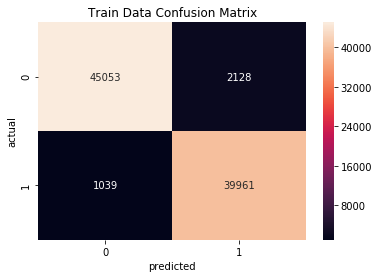

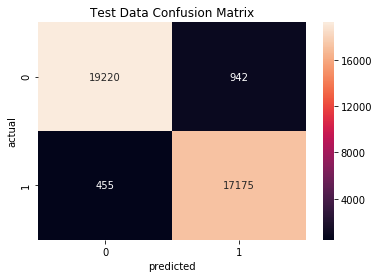

In [253]:
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()

In [254]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.9640852337805196
The overall accuracy score for the Test Data  is :  0.9630345046570703


In [256]:
train_gini = 2*metrics.roc_auc_score(train_predict.actual, train_predict.predicted) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_predict.actual, test_predict.predicted) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

train_auc = metrics.roc_auc_score(train_predict.actual, train_predict.predicted)
test_auc = metrics.roc_auc_score(test_predict.actual, test_predict.predicted)

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

train_accuracy = metrics.accuracy_score(train_predict.actual, train_predict.predicted)
test_accuracy = metrics.accuracy_score(test_predict.actual, test_predict.predicted)

print("The Accuracy for the model built on the Train Data is : ", train_accuracy)
print("The Accuracy for the model built on the Test Data is : ", test_accuracy)

The Gini Index for the model built on the Train Data is :  0.9295556349936234
The Gini Index for the model built on the Test Data is :  0.9274701632601228
The AUC for the model built on the Train Data is :  0.9647778174968117
The AUC for the model built on the Test Data is :  0.9637350816300614
The Accuracy for the model built on the Train Data is :  0.9640852337805196
The Accuracy for the model built on the Test Data is :  0.9630345046570703


In [73]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)
test_predict['Deciles']=pd.qcut(test_predict['prob'],10, labels=False)

no_1s = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)['actual']
no_total = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).count().sort_index(ascending=False)['actual']
max_prob = train_predict[['Deciles','prob']].groupby(train_predict.Deciles).max().sort_index(ascending=False)['prob']
min_prob = train_predict[['Deciles','prob']].groupby(train_predict.Deciles).min().sort_index(ascending=False)['prob']

Decile_analysis_train = pd.concat([max_prob, min_prob, no_1s, no_total-no_1s, no_total],axis=1)
Decile_analysis_train.columns = ['max_prob','min_prob','no_1','no_0','total']
Decile_analysis_train

max_prob      min_prob  no_1  no_0  total
Deciles                                           
9        1.000000  9.997235e-01  8617   201   8818
8        0.999723  9.976343e-01  8773    44   8817
7        0.997632  9.783248e-01  8692   126   8818
6        0.978314  8.823118e-01  8365   454   8819
5        0.882294  2.136620e-01  6160  2658   8818
4        0.213613  4.136452e-02   376  8442   8818
3        0.041364  1.891040e-02     7  8811   8818
2        0.018910  7.651882e-03     0  8818   8818
1        0.007651  1.822117e-03     3  8815   8818
0        0.001822  1.387586e-09     7  8812   8819

In [74]:
no_1s = test_predict[['Deciles','actual']].groupby(test_predict.Deciles).sum().sort_index(ascending=False)['actual']
no_total = test_predict[['Deciles','actual']].groupby(test_predict.Deciles).count().sort_index(ascending=False)['actual']
max_prob = test_predict[['Deciles','prob']].groupby(test_predict.Deciles).max().sort_index(ascending=False)['prob']
min_prob = test_predict[['Deciles','prob']].groupby(test_predict.Deciles).min().sort_index(ascending=False)['prob']

Decile_analysis_test = pd.concat([max_prob, min_prob, no_1s, no_total-no_1s, no_total], axis=1)
Decile_analysis_test.columns = ['max_prob','min_prob','no_1','no_0','total']
Decile_analysis_test

max_prob      min_prob  no_1  no_0  total
Deciles                                           
9        1.000000  9.997078e-01  3684    96   3780
8        0.999707  9.975702e-01  3752    27   3779
7        0.997568  9.786028e-01  3720    59   3779
6        0.978593  8.823802e-01  3551   225   3776
5        0.882287  2.328032e-01  2715  1067   3782
4        0.232558  4.260208e-02   203  3574   3777
3        0.042595  1.907001e-02     0  3780   3780
2        0.019068  7.412052e-03     3  3777   3780
1        0.007412  1.824701e-03     0  3779   3779
0        0.001824  1.364601e-09     2  3778   3780

#### 2. XGBoost Classifier

In [81]:
n_estimators = [100,500,1000]
ROC_scores = []

for i in n_estimators:
    xg = XGBClassifier(n_estimators = i, random_state=123)
    ROC = cross_val_score(xg, train_X, train_y, scoring='roc_auc')
    ROC_scores.append(np.mean(ROC))

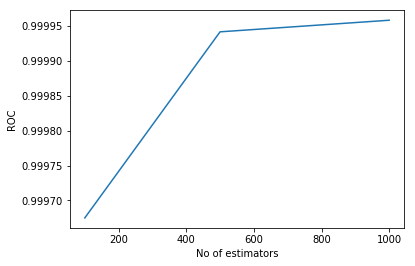

In [82]:
plt.plot(n_estimators,ROC_scores)
plt.xlabel('No of estimators')
plt.ylabel('ROC')
plt.show()

In [83]:
max_depth = [3,5,7,9]
ROC_scores = []

for i in max_depth:
    xg = XGBClassifier(max_depth = i, random_state=123)
    ROC = cross_val_score(xg, train_X, train_y, scoring='roc_auc')
    ROC_scores.append(np.mean(ROC))

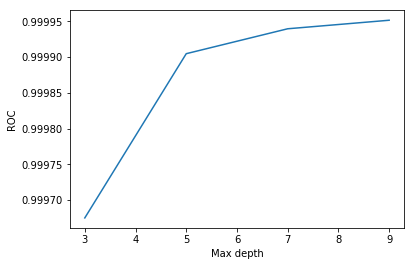

In [84]:
plt.plot(max_depth,ROC_scores)
plt.xlabel('Max depth')
plt.ylabel('ROC')
plt.show()

In [257]:
xgb = XGBClassifier(n_estimators=1000,max_depth=9)
xgb.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [258]:
train_predicted = xgb.predict(train_X)
test_predicted = xgb.predict(test_X)

metrics.confusion_matrix(y_pred=test_predicted,y_true=test_y)

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[20121,    41],
       [   42, 17588]], dtype=int64)

In [259]:
train_gini = 2*metrics.roc_auc_score(train['target'], train_predicted) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test['target'], test_predicted) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

train_auc = metrics.roc_auc_score(train['target'], train_predicted)
test_auc = metrics.roc_auc_score(test['target'], test_predicted)

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

train_accuracy = metrics.accuracy_score(y_true=train['target'], y_pred=train_predicted)
test_accuracy = metrics.accuracy_score(y_true=test['target'], y_pred=test_predicted)

print("The Accuracy for the model built on the Train Data is : ", train_accuracy)
print("The Accuracy for the model built on the Test Data is : ", test_accuracy)

The Gini Index for the model built on the Train Data is :  0.9994605398721372
The Gini Index for the model built on the Test Data is :  0.9955841686874038
The AUC for the model built on the Train Data is :  0.9997302699360686
The AUC for the model built on the Test Data is :  0.9977920843437019
The Accuracy for the model built on the Train Data is :  0.9997164922148762
The Accuracy for the model built on the Test Data is :  0.9978037679932261


In [260]:
feature_map = [(i, v) for i, v in itertools.zip_longest(train_X.columns, xgb.feature_importances_)]
Feature_importance = pd.DataFrame(feature_map, columns=['Feature', 'importance'])
Feature_importance.sort_values('importance', inplace=True, ascending=False)
Feature_importance

Feature  importance
2                     dst_bytes    0.605159
0                         count    0.132841
10              service_private    0.102296
7                     last_flag    0.077919
5   dst_host_same_src_port_rate    0.027126
1                 diff_srv_rate    0.011666
4        dst_host_diff_srv_rate    0.011416
11           srv_diff_host_rate    0.009297
8                   rerror_rate    0.007785
9              service_domain_u    0.006064
3                dst_host_count    0.004967
6   dst_host_srv_diff_host_rate    0.003463

In [274]:
d1 = data.groupby(by=['target'])[['dst_bytes']].mean().reset_index(drop=False)
d1

target     dst_bytes
0       0   4329.685223
1       1  37524.482159

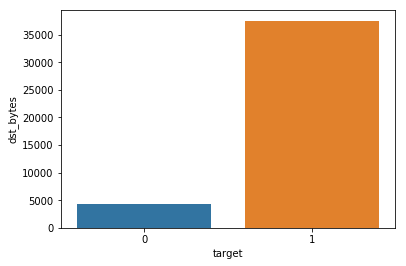

In [276]:
sns.barplot(data=d1, x='target',y='dst_bytes')
plt.show()

In [279]:
d2 = data.groupby(by=['target'])[['count']].mean().reset_index(drop=False)
d2

target       count
0       0   22.517945
1       1  154.849991

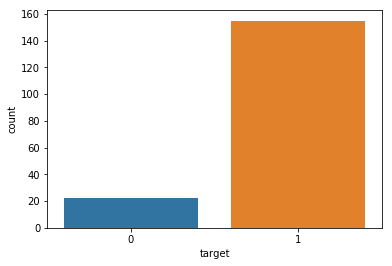

In [278]:
sns.barplot(data=d2, x='target',y='count')
plt.show()

#### 3. Random Forest

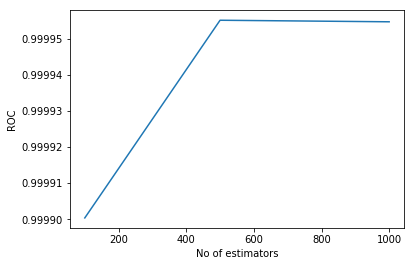

In [96]:
n_estimators = [100,500,1000]
ROC_scores = []

for i in n_estimators:
    rf = RandomForestClassifier(n_estimators = i, random_state=123)
    ROC = cross_val_score(rf, train_X, train_y, scoring='roc_auc')
    ROC_scores.append(np.mean(ROC))

plt.plot(n_estimators,ROC_scores)
plt.xlabel('No of estimators')
plt.ylabel('ROC')
plt.show()

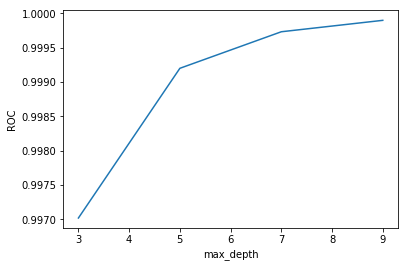

In [97]:
max_depth = [3,5,7,9]
ROC_scores = []

for i in max_depth:
    rf = RandomForestClassifier(max_depth = i, random_state=123,n_estimators=100)
    ROC = cross_val_score(rf, train_X, train_y, scoring='roc_auc')
    ROC_scores.append(np.mean(ROC))

plt.plot(max_depth,ROC_scores)
plt.xlabel('max_depth')
plt.ylabel('ROC')
plt.show()

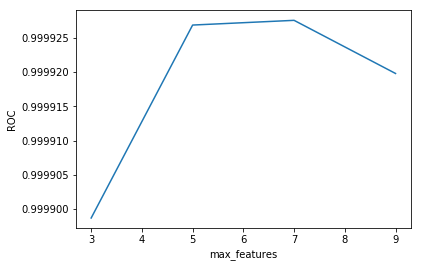

In [102]:
max_features = [3,5,7,9]
ROC_scores = []

for i in max_features:
    rf = RandomForestClassifier(max_features = i, random_state=123,n_estimators=100,max_depth=9)
    ROC = cross_val_score(rf, train_X, train_y, scoring='roc_auc')
    ROC_scores.append(np.mean(ROC))

plt.plot(max_depth,ROC_scores)
plt.xlabel('max_features')
plt.ylabel('ROC')
plt.show()

In [103]:
random_forest = RandomForestClassifier(n_estimators=100,oob_score=True,max_depth=9,max_features=7,random_state=123)
random_forest.fit(train_X, train_y)

train_predicted = random_forest.predict(train_X)
test_predicted = random_forest.predict(test_X)

metrics.confusion_matrix(y_pred=test_predicted,y_true=test_y)

array([[20075,    87],
       [   79, 17551]], dtype=int64)

In [104]:
train_predicted = random_forest.predict(train_X)
test_predicted = random_forest.predict(test_X)

metrics.confusion_matrix(y_pred=test_predicted,y_true=test_y)

array([[20075,    87],
       [   79, 17551]], dtype=int64)

In [105]:
train_gini = 2*metrics.roc_auc_score(train['target'], train_predicted) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test['target'], test_predicted) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

train_auc = metrics.roc_auc_score(train['target'], train_predicted)
test_auc = metrics.roc_auc_score(test['target'], test_predicted)

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

train_accuracy = metrics.accuracy_score(y_true=train['target'], y_pred=train_predicted)
test_accuracy = metrics.accuracy_score(y_true=test['target'], y_pred=test_predicted)

print("The Accuracy for the model built on the Train Data is : ", train_accuracy)
print("The Accuracy for the model built on the Test Data is : ", test_accuracy)

The Gini Index for the model built on the Train Data is :  0.9936572643700623
The Gini Index for the model built on the Test Data is :  0.9912039535913384
The AUC for the model built on the Train Data is :  0.9968286321850311
The AUC for the model built on the Test Data is :  0.9956019767956692
The Accuracy for the model built on the Train Data is :  0.9968473934294235
The Accuracy for the model built on the Test Data is :  0.9956075359864521


In [106]:
feature_map = [(i, v) for i, v in itertools.zip_longest(train_X.columns, xgb.feature_importances_)]
Feature_importance = pd.DataFrame(feature_map, columns=['Feature', 'importance'])
Feature_importance.sort_values('importance', inplace=True, ascending=False)
Feature_importance

Feature  importance
2                     dst_bytes    0.605159
0                         count    0.132841
10              service_private    0.102296
7                     last_flag    0.077919
5   dst_host_same_src_port_rate    0.027126
1                 diff_srv_rate    0.011666
4        dst_host_diff_srv_rate    0.011416
11           srv_diff_host_rate    0.009297
8                   rerror_rate    0.007785
9              service_domain_u    0.006064
3                dst_host_count    0.004967
6   dst_host_srv_diff_host_rate    0.003463

### Mutlinomial Classification

Import the dataset

In [280]:
data = pd.read_csv('C:\\Analytix\\Git\\Analytix\\Projects\\3. Network Intrusion Detection System\\NSL_Dataset\\train.txt',header=None)
data.head()

0    1         2   3    4     5   6   7   8   9  ...    33    34    35  \
0   0  tcp  ftp_data  SF  491     0   0   0   0   0 ...  0.17  0.03  0.17   
1   0  udp     other  SF  146     0   0   0   0   0 ...  0.00  0.60  0.88   
2   0  tcp   private  S0    0     0   0   0   0   0 ...  0.10  0.05  0.00   
3   0  tcp      http  SF  232  8153   0   0   0   0 ...  1.00  0.00  0.03   
4   0  tcp      http  SF  199   420   0   0   0   0 ...  1.00  0.00  0.00   

     36    37    38    39    40       41  42  
0  0.00  0.00  0.00  0.05  0.00   normal  20  
1  0.00  0.00  0.00  0.00  0.00   normal  15  
2  0.00  1.00  1.00  0.00  0.00  neptune  19  
3  0.04  0.03  0.01  0.00  0.01   normal  21  
4  0.00  0.00  0.00  0.00  0.00   normal  21  

[5 rows x 43 columns]

In [281]:
data.columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land", "wrong_fragment","urgent","hot","num_failed_logins","logged_in", "num_compromised","root_shell","su_attempted","num_root","num_file_creations", "num_shells","num_access_files","num_outbound_cmds","is_host_login", "is_guest_login","count","srv_count","serror_rate", "srv_serror_rate", "rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate", "dst_host_diff_srv_rate","dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate", "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]
data.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot    ...      dst_host_same_srv_rate  \
0               0       0    0    ...                        0.17   
1               0       0    0    ...                        0.00   
2               0       0    0    ...                        0.10   
3               0       0    0    ...                        1.00   
4               0       0    0    ...                        1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   
2                    0.05                         0.00   
3                    0.00                         0.03   
4                    0.00                         0.00   

   dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                         0.00                  0.00   
1                         0.00                  0.00   
2                         0.00                  1.00   
3                         0.04                  0.03   
4                         0.00                  0.00   

   dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate  \
0                      0.00                  0.05                      0.00   
1                      0.00                  0.00                      0.00   
2                      1.00                  0.00                      0.00   
3                      0.01                  0.00                      0.01   
4                      0.00                  0.00                      0.00   

    attack  last_flag  
0   normal         20  
1   normal         15  
2  neptune         19  
3   normal         21  
4   normal         21  

[5 rows x 43 columns]

Create the target variable

In [282]:
def MultiNomialTargetFunc(x):
    if x in ['back', 'land', 'neptune', 'pod', 'smurf','teardrop','apache2', 'udpstorm', 'processtable', 'worm']:
        #Dos
        return 1
    elif x in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint' ]:
        #Probe
        return 2
    elif x in ['guess_password','guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named' ]:
        #R2L
        return 3
    elif x in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps' ]:
        #U2R
        return 4
    elif x in ['normal']:
        #normal
        return 0
    else:
        print("Category not found for {}".format(x))
        return x

In [283]:
data['target'] = data.attack.apply(lambda x: MultiNomialTargetFunc(x))
data.drop(columns=['attack'],axis=1, inplace=True)

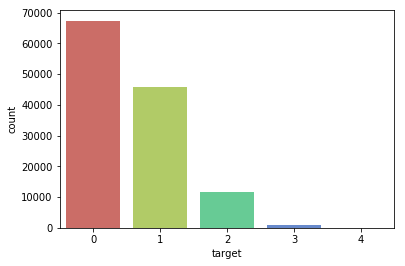

In [284]:
sns.countplot(x='target',data=data, palette='hls')
plt.show()

In [285]:
data.groupby('target').mean()

duration      src_bytes      dst_bytes      land  wrong_fragment  \
target                                                                        
0        168.587396   13133.279331    4329.685223  0.000104        0.000000   
1          0.006227    1176.321162     169.201537  0.000392        0.062229   
2       2074.858185  385679.838367  181074.911805  0.000000        0.000000   
3        633.417085  307727.300503   81822.026131  0.000000        0.000000   
4         80.942308     906.230769    5141.961538  0.000000        0.000000   

          urgent       hot  num_failed_logins  logged_in  num_compromised  \
target                                                                      
0       0.000148  0.230655           0.001381   0.710646         0.507076   
1       0.000000  0.039889           0.000000   0.020837         0.019226   
2       0.000000  0.001630           0.000343   0.007121         0.000601   
3       0.003015  8.334673           0.056281   0.913568         0.077387   
4       0.019231  1.403846           0.019231   0.884615         1.211538   

          ...      dst_host_srv_count  dst_host_same_srv_rate  \
target    ...                                                   
0         ...              190.285761                0.811875   
1         ...               26.524005                0.123423   
2         ...               42.367193                0.390825   
3         ...               42.440201                0.727377   
4         ...                9.884615                0.781154   

        dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
target                                                        
0                     0.040134                     0.121726   
1                     0.066333                     0.049492   
2                     0.401263                     0.651840   
3                     0.021307                     0.596915   
4                     0.040000                     0.568269   

        dst_host_srv_diff_host_rate  dst_host_serror_rate  \
target                                                      
0                          0.025996              0.013930   
1                          0.001647              0.747922   
2                          0.187343              0.044757   
3                          0.085739              0.023849   
4                          0.081154              0.000000   

        dst_host_srv_serror_rate  dst_host_rerror_rate  \
target                                                   
0                       0.006116              0.046589   
1                       0.744434              0.157569   
2                       0.039799              0.389717   
3                       0.015960              0.051116   
4                       0.004808              0.039615   

        dst_host_srv_rerror_rate  last_flag  
target                                       
0                       0.044698  20.315920  
1                       0.151286  19.311560  
2                       0.441030  16.461050  
3                       0.047367   9.878392  
4                       0.019038   4.403846  

[5 rows x 39 columns]

In [286]:
nominal_vars = ['protocol_type', 'service', 'flag']
binary_vars = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
target = ['target']
numeric = data.columns.difference(nominal_vars + binary_vars + target)

In [287]:
categorical = nominal_vars + binary_vars + target

In [288]:
data_num = data[numeric]
data_cat = data[categorical]

#### Outlier Treatment

In [289]:
def outlierCapping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

#### Missing value Treatment

In [290]:
def missingImputation(x):
    x = x.fillna(x.mean())
    return x
def missingImputationCat(x):
    x = x.fillna(x.mode())
    return x

In [291]:
data_num = data_num.apply(lambda x: outlierCapping(x))

In [292]:
data_num = data_num.apply(lambda x: missingImputation(x))
data_cat = data_cat.apply(lambda x: missingImputationCat(x.astype('str')))

In [293]:
data[numeric].describe()

count  diff_srv_rate     dst_bytes  dst_host_count  \
count  125973.000000  125973.000000  1.259730e+05   125973.000000   
mean       84.107555       0.063053  1.977911e+04      182.148945   
std       114.508607       0.180314  4.021269e+06       99.206213   
min         0.000000       0.000000  0.000000e+00        0.000000   
25%         2.000000       0.000000  0.000000e+00       82.000000   
50%        14.000000       0.000000  0.000000e+00      255.000000   
75%       143.000000       0.060000  5.160000e+02      255.000000   
max       511.000000       1.000000  1.309937e+09      255.000000   

       dst_host_diff_srv_rate  dst_host_rerror_rate  \
count           125973.000000         125973.000000   
mean                 0.082951              0.118832   
std                  0.188922              0.306557   
min                  0.000000              0.000000   
25%                  0.000000              0.000000   
50%                  0.020000              0.000000   
75%                  0.070000              0.000000   
max                  1.000000              1.000000   

       dst_host_same_src_port_rate  dst_host_same_srv_rate  \
count                125973.000000           125973.000000   
mean                      0.148379                0.521242   
std                       0.308997                0.448949   
min                       0.000000                0.000000   
25%                       0.000000                0.050000   
50%                       0.000000                0.510000   
75%                       0.060000                1.000000   
max                       1.000000                1.000000   

       dst_host_serror_rate  dst_host_srv_count       ...        \
count         125973.000000       125973.000000       ...         
mean               0.284452          115.653005       ...         
std                0.444784          110.702741       ...         
min                0.000000            0.000000       ...         
25%                0.000000           10.000000       ...         
50%                0.000000           63.000000       ...         
75%                1.000000          255.000000       ...         
max                1.000000          255.000000       ...         

         rerror_rate  same_srv_rate    serror_rate     src_bytes  \
count  125973.000000  125973.000000  125973.000000  1.259730e+05   
mean        0.119958       0.660928       0.284485  4.556674e+04   
std         0.320436       0.439623       0.446456  5.870331e+06   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%         0.000000       0.090000       0.000000  0.000000e+00   
50%         0.000000       1.000000       0.000000  4.400000e+01   
75%         0.000000       1.000000       1.000000  2.760000e+02   
max         1.000000       1.000000       1.000000  1.379964e+09   

           srv_count  srv_diff_host_rate  srv_rerror_rate  srv_serror_rate  \
count  125973.000000       125973.000000    125973.000000    125973.000000   
mean       27.737888            0.097322         0.121183         0.282485   
std        72.635840            0.259830         0.323647         0.447022   
min         0.000000            0.000000         0.000000         0.000000   
25%         2.000000            0.000000         0.000000         0.000000   
50%         8.000000            0.000000         0.000000         0.000000   
75%        18.000000            0.000000         0.000000         1.000000   
max       511.000000            1.000000         1.000000         1.000000   

              urgent  wrong_fragment  
count  125973.000000   125973.000000  
mean        0.000111        0.022687  
std         0.014366        0.253530  
min         0.000000        0.000000  
25%         0.000000        0.000000  
50%         0.000000        0.000000  
75%         0.000000        0.000000  
max         3.000000        3.000000  

[8 rows x 33 columns]

In [294]:
data_num.describe()

count  diff_srv_rate      dst_bytes  dst_host_count  \
count  125973.000000  125973.000000  125973.000000   125973.000000   
mean       84.107658       0.063053    1342.118549      182.148968   
std       114.508532       0.180314    3804.294003       99.206169   
min         1.000000       0.000000       0.000000        1.000000   
25%         2.000000       0.000000       0.000000       82.000000   
50%        14.000000       0.000000       0.000000      255.000000   
75%       143.000000       0.060000     516.000000      255.000000   
max       511.000000       1.000000   25519.000000      255.000000   

       dst_host_diff_srv_rate  dst_host_rerror_rate  \
count           125973.000000         125973.000000   
mean                 0.082951              0.118832   
std                  0.188922              0.306557   
min                  0.000000              0.000000   
25%                  0.000000              0.000000   
50%                  0.020000              0.000000   
75%                  0.070000              0.000000   
max                  1.000000              1.000000   

       dst_host_same_src_port_rate  dst_host_same_srv_rate  \
count                125973.000000           125973.000000   
mean                      0.148379                0.521242   
std                       0.308997                0.448949   
min                       0.000000                0.000000   
25%                       0.000000                0.050000   
50%                       0.000000                0.510000   
75%                       0.060000                1.000000   
max                       1.000000                1.000000   

       dst_host_serror_rate  dst_host_srv_count       ...        \
count         125973.000000       125973.000000       ...         
mean               0.284452          115.653029       ...         
std                0.444784          110.702716       ...         
min                0.000000            1.000000       ...         
25%                0.000000           10.000000       ...         
50%                0.000000           63.000000       ...         
75%                1.000000          255.000000       ...         
max                1.000000          255.000000       ...         

         rerror_rate  same_srv_rate    serror_rate      src_bytes  \
count  125973.000000  125973.000000  125973.000000  125973.000000   
mean        0.119958       0.660928       0.284485    1029.498123   
std         0.320436       0.439623       0.446456    6137.901578   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.090000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000      44.000000   
75%         0.000000       1.000000       1.000000     276.000000   
max         1.000000       1.000000       1.000000   54540.000000   

           srv_count  srv_diff_host_rate  srv_rerror_rate  srv_serror_rate  \
count  125973.000000       125973.000000    125973.000000    125973.000000   
mean       27.553158            0.097322         0.121183         0.282485   
std        71.420190            0.259830         0.323647         0.447022   
min         1.000000            0.000000         0.000000         0.000000   
25%         2.000000            0.000000         0.000000         0.000000   
50%         8.000000            0.000000         0.000000         0.000000   
75%        18.000000            0.000000         0.000000         1.000000   
max       492.000000            1.000000         1.000000         1.000000   

         urgent  wrong_fragment  
count  125973.0        125973.0  
mean        0.0             0.0  
std         0.0             0.0  
min         0.0             0.0  
25%         0.0             0.0  
50%         0.0             0.0  
75%         0.0             0.0  
max         0.0             0.0  

[8 rows x 33 columns]

#### Dummy Variable Creation

In [295]:
def createDummyVariables(df,col):
    df_dummy = pd.get_dummies(data=df[col],drop_first=True,prefix=col)
    df = pd.concat([df,df_dummy],axis=1)
    df.drop(col,axis=1,inplace=True)
    return df

In [296]:
data_cat_new = data_cat
for feature in data_cat.columns.difference(['target']):
    data_cat_new = createDummyVariables(data_cat_new,feature)
data_cat_new.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 89 columns):
target                 125973 non-null object
flag_REJ               125973 non-null uint8
flag_RSTO              125973 non-null uint8
flag_RSTOS0            125973 non-null uint8
flag_RSTR              125973 non-null uint8
flag_S0                125973 non-null uint8
flag_S1                125973 non-null uint8
flag_S2                125973 non-null uint8
flag_S3                125973 non-null uint8
flag_SF                125973 non-null uint8
flag_SH                125973 non-null uint8
is_guest_login_1       125973 non-null uint8
is_host_login_1        125973 non-null uint8
land_1                 125973 non-null uint8
logged_in_1            125973 non-null uint8
protocol_type_tcp      125973 non-null uint8
protocol_type_udp      125973 non-null uint8
root_shell_1           125973 non-null uint8
service_X11            125973 non-null uint8
service_Z39_50         125973 non

In [297]:
data_cat_new.head()

target  flag_REJ  flag_RSTO  flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  \
0      0         0          0            0          0        0        0   
1      0         0          0            0          0        0        0   
2      1         0          0            0          0        1        0   
3      0         0          0            0          0        0        0   
4      0         0          0            0          0        0        0   

   flag_S2  flag_S3  flag_SF       ...        service_tim_i  service_time  \
0        0        0        1       ...                    0             0   
1        0        0        1       ...                    0             0   
2        0        0        0       ...                    0             0   
3        0        0        1       ...                    0             0   
4        0        0        1       ...                    0             0   

   service_urh_i  service_urp_i  service_uucp  service_uucp_path  \
0              0              0             0                  0   
1              0              0             0                  0   
2              0              0             0                  0   
3              0              0             0                  0   
4              0              0             0                  0   

   service_vmnet  service_whois  su_attempted_1  su_attempted_2  
0              0              0               0               0  
1              0              0               0               0  
2              0              0               0               0  
3              0              0               0               0  
4              0              0               0               0  

[5 rows x 89 columns]

In [298]:
temp = data_num.describe().T
temp[temp['std'] == 0]

count  mean  std  min  25%  50%  75%  max
num_access_files    125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_failed_logins   125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_file_creations  125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_outbound_cmds   125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_root            125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
num_shells          125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
urgent              125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
wrong_fragment      125973.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

Drop the variables with zero variances

In [299]:
data_num.drop(columns=['num_access_files',
                      'num_failed_logins',
                      'num_file_creations',
                      'num_outbound_cmds',
                      'num_root',
                      'num_shells',
                      'urgent',
                      'wrong_fragment'], axis=1, inplace=True)

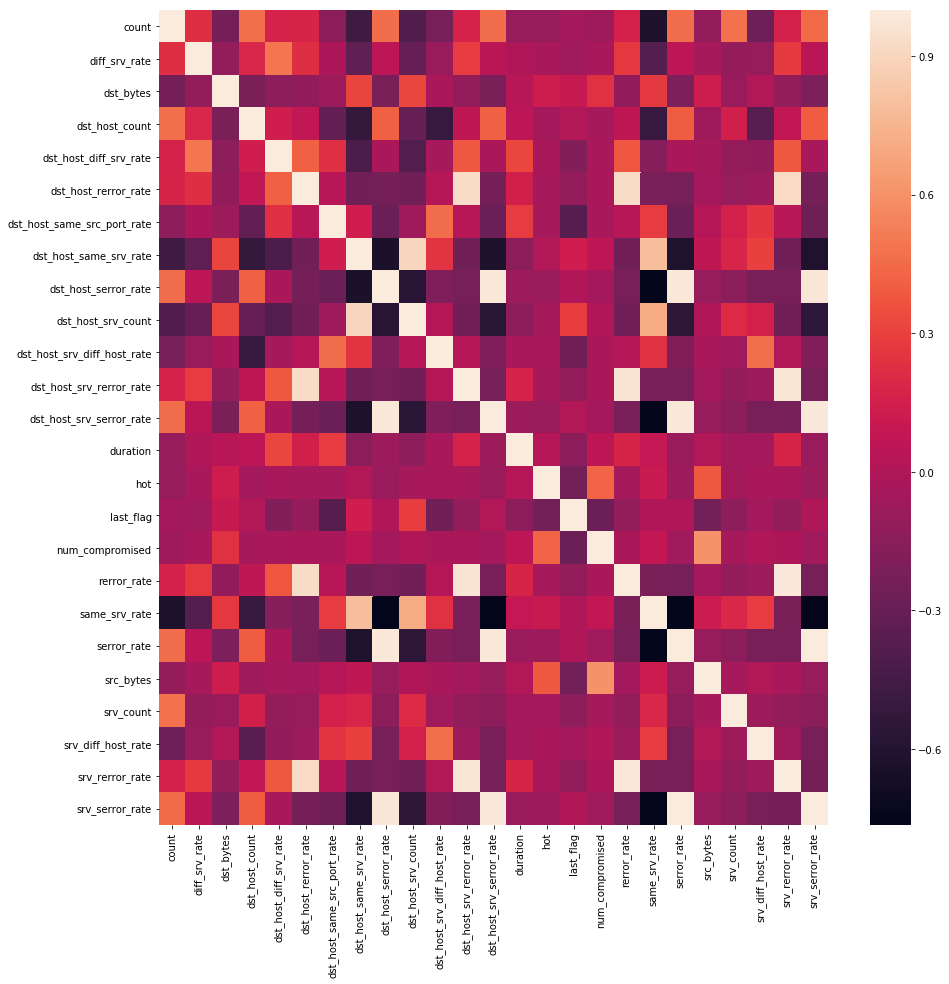

In [300]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data_num.corr())
plt.show()

In [301]:
corrm = data_num.corr()
corrm.to_csv('corrm.csv')

Drop the variables having less correlation with the target

In [302]:
data_num.drop(columns=['dst_host_rerror_rate',
                      'dst_host_serror_rate',
                      'dst_host_srv_rerror_rate',
                      'dst_host_srv_serror_rate',
                      'dst_host_same_srv_rate',
                      'srv_rerror_rate',
                      'srv_serror_rate'], inplace=True, axis=1)

#### WOE or log odds

In [303]:
data_new = pd.concat([data_num, data_cat_new], axis=1)
data_new.target = pd.to_numeric(data_new.target)
data_new.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 107 columns):
count                          125973 non-null float64
diff_srv_rate                  125973 non-null float64
dst_bytes                      125973 non-null float64
dst_host_count                 125973 non-null float64
dst_host_diff_srv_rate         125973 non-null float64
dst_host_same_src_port_rate    125973 non-null float64
dst_host_srv_count             125973 non-null float64
dst_host_srv_diff_host_rate    125973 non-null float64
duration                       125973 non-null float64
hot                            125973 non-null float64
last_flag                      125973 non-null float64
num_compromised                125973 non-null float64
rerror_rate                    125973 non-null float64
same_srv_rate                  125973 non-null float64
serror_rate                    125973 non-null float64
src_bytes                      125973 non-null float64
srv_coun

In [311]:
data_new.columns

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'duration', 'hot',
       ...
       'service_tim_i', 'service_time', 'service_urh_i', 'service_urp_i',
       'service_uucp', 'service_uucp_path', 'service_vmnet', 'service_whois',
       'su_attempted_1', 'su_attempted_2'],
      dtype='object', length=107)

#### RFE

In [312]:
X = data_new[data_new.columns.difference(['target'])]
logreg = LogisticRegression()
rfe = RFE(logreg, 15)
rfe = rfe.fit(X, data_new['target'])

In [313]:
rfe_features = X.columns[rfe.get_support()]
selected_features_from_RFE = X[rfe_features]
selected_features_from_RFE.head()

diff_srv_rate  dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0           0.00                    0.03                         0.17   
1           0.15                    0.60                         0.88   
2           0.07                    0.05                         0.00   
3           0.00                    0.00                         0.03   
4           0.00                    0.00                         0.00   

   dst_host_srv_diff_host_rate  flag_S0  flag_S1  num_compromised  \
0                         0.00        0        0              0.0   
1                         0.00        0        0              0.0   
2                         0.00        1        0              0.0   
3                         0.04        0        0              0.0   
4                         0.00        0        0              0.0   

   rerror_rate  root_shell_1  same_srv_rate  serror_rate  service_eco_i  \
0          0.0             0           1.00          0.0              0   
1          0.0             0           0.08          0.0              0   
2          0.0             0           0.05          1.0              0   
3          0.0             0           1.00          0.2              0   
4          0.0             0           1.00          0.0              0   

   service_ecr_i  service_http  service_private  
0              0             0                0  
1              0             0                0  
2              0             0                1  
3              0             1                0  
4              0             1                0

#### SelectKBest

In [315]:
X = data_new[data_new.columns.difference(['target'])]
skb = SelectKBest(f_classif, k=15).fit(X, data_new[['target']] )

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [316]:
skb_features = X.columns[skb.get_support()]
selected_features_from_selectKBest = X[skb_features]
selected_features_from_selectKBest.head()

count  dst_host_count  dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0    2.0           150.0                    0.03                         0.17   
1   13.0           255.0                    0.60                         0.88   
2  123.0           255.0                    0.05                         0.00   
3    5.0            30.0                    0.00                         0.03   
4   30.0           255.0                    0.00                         0.00   

   dst_host_srv_count  dst_host_srv_diff_host_rate  flag_S0  flag_SF  \
0                25.0                         0.00        0        1   
1                 1.0                         0.00        0        1   
2                26.0                         0.00        1        0   
3               255.0                         0.04        0        1   
4               255.0                         0.00        0        1   

   last_flag  logged_in_1  same_srv_rate  serror_rate  service_eco_i  \
0       20.0            0           1.00          0.0              0   
1       15.0            0           0.08          0.0              0   
2       19.0            0           0.05          1.0              0   
3       21.0            1           1.00          0.2              0   
4       21.0            1           1.00          0.0              0   

   service_http  service_private  
0             0                0  
1             0                0  
2             0                1  
3             1                0  
4             1                0

In [317]:
selected_features_final = set([])
for x,y in itertools.zip_longest(selected_features_from_RFE.columns,selected_features_from_selectKBest.columns):
    if(x):
        selected_features_final.add(x) 
    if(y):
        selected_features_final.add(y)

Final selected features from RFE and SelectKBest

In [318]:
list(selected_features_final)

['service_eco_i',
 'dst_host_srv_diff_host_rate',
 'dst_host_diff_srv_rate',
 'dst_host_count',
 'flag_S1',
 'diff_srv_rate',
 'logged_in_1',
 'num_compromised',
 'last_flag',
 'flag_S0',
 'flag_SF',
 'rerror_rate',
 'dst_host_srv_count',
 'service_private',
 'count',
 'dst_host_same_src_port_rate',
 'service_ecr_i',
 'service_http',
 'serror_rate',
 'root_shell_1',
 'same_srv_rate']

#### VIF

In [319]:
formula = 'target~' + '+'.join(selected_features_final)
formula

'target~service_eco_i+dst_host_srv_diff_host_rate+dst_host_diff_srv_rate+dst_host_count+flag_S1+diff_srv_rate+logged_in_1+num_compromised+last_flag+flag_S0+flag_SF+rerror_rate+dst_host_srv_count+service_private+count+dst_host_same_src_port_rate+service_ecr_i+service_http+serror_rate+root_shell_1+same_srv_rate'

In [321]:
a,b = dmatrices(formula_like='target~rerror_rate+service_eco_i+dst_host_count+num_compromised+service_ecr_i+dst_host_diff_srv_rate+service_private+diff_srv_rate+flag_S0+service_http+root_shell_1+flag_S1+last_flag', data = data_new, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print("No of features-->",vif.shape[0])
vif.sort_values(by=['VIF Factor'],ascending=False)

No of features--> 14


VIF Factor                features
0   140.606384               Intercept
10    1.776029            service_http
9     1.623828                 flag_S0
6     1.617603  dst_host_diff_srv_rate
13    1.504505               last_flag
3     1.496826          dst_host_count
8     1.385100           diff_srv_rate
2     1.366488           service_eco_i
1     1.335029             rerror_rate
7     1.286339         service_private
4     1.209295         num_compromised
5     1.088906           service_ecr_i
11    1.052933            root_shell_1
12    1.015203                 flag_S1

In [322]:
final_features = []
for i in vif.features:
    if(i != 'Intercept'):
        final_features.append(i)

Final features used for modelling

In [323]:
final_features

['rerror_rate',
 'service_eco_i',
 'dst_host_count',
 'num_compromised',
 'service_ecr_i',
 'dst_host_diff_srv_rate',
 'service_private',
 'diff_srv_rate',
 'flag_S0',
 'service_http',
 'root_shell_1',
 'flag_S1',
 'last_flag']

In [325]:
data_final = data_new[final_features + ['target']]
data_final.head()

rerror_rate  service_eco_i  dst_host_count  num_compromised  service_ecr_i  \
0          0.0              0           150.0              0.0              0   
1          0.0              0           255.0              0.0              0   
2          0.0              0           255.0              0.0              0   
3          0.0              0            30.0              0.0              0   
4          0.0              0           255.0              0.0              0   

   dst_host_diff_srv_rate  service_private  diff_srv_rate  flag_S0  \
0                    0.03                0           0.00        0   
1                    0.60                0           0.15        0   
2                    0.05                1           0.07        1   
3                    0.00                0           0.00        0   
4                    0.00                0           0.00        0   

   service_http  root_shell_1  flag_S1  last_flag  target  
0             0             0        0       20.0       0  
1             0             0        0       15.0       0  
2             0             0        0       19.0       1  
3             1             0        0       21.0       0  
4             1             0        0       21.0       0

Train/Test split

In [326]:
train,test = train_test_split(data_final,test_size=0.3,random_state=123)

train_X = train[train.columns.difference(['target'])]
test_X = test[test.columns.difference(['target'])]
train_y = train['target']
test_y = test['target']

#### Model Building

#### 1. XGBoost

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\

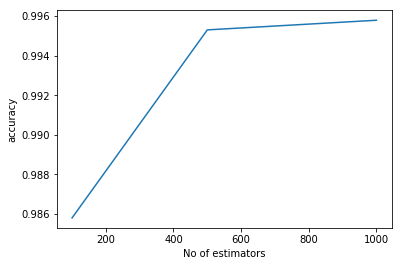

In [152]:
n_estimators = [100,500,1000]
accuracy = []

for i in n_estimators:
    xg = XGBClassifier(n_estimators = i, random_state=123)
    acc = cross_val_score(xg, train_X, train_y, scoring='accuracy')
    accuracy.append(np.mean(acc))
    
plt.plot(n_estimators,accuracy)
plt.xlabel('No of estimators')
plt.ylabel('accuracy')
plt.show()

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\

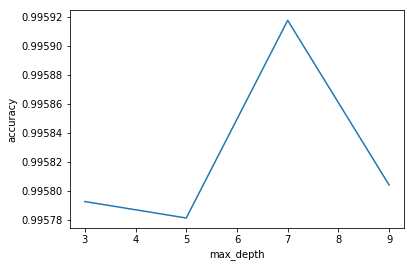

In [154]:
max_depth = [3,5,7,9]
accuracy = []

for i in max_depth:
    xg = XGBClassifier(max_depth= i, random_state=123,n_estimators=1000)
    acc = cross_val_score(xg, train_X, train_y, scoring='accuracy')
    accuracy.append(np.mean(acc))
    
plt.plot(max_depth,accuracy)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

In [155]:
xgb = XGBClassifier(n_estimators=500,max_depth=7)
xgb.fit(train_X, train_y)
train_predicted = xgb.predict(train_X)
test_predicted = xgb.predict(test_X)

metrics.confusion_matrix(y_pred=test_predicted,y_true=test_y)

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[20078,    21,    14,    49,     0],
       [   14, 13841,     6,     0,     0],
       [   13,     4,  3440,     4,     1],
       [   15,     0,     4,   276,     0],
       [    0,     0,     1,     6,     5]], dtype=int64)

In [169]:
train_accuracy = metrics.accuracy_score(y_true=train['target'], y_pred=train_predicted)
test_accuracy = metrics.accuracy_score(y_true=test['target'], y_pred=test_predicted)

print("The Accuracy for the model built on the Train Data is : ", train_accuracy)
print("The Accuracy for the model built on the Test Data is : ", test_accuracy)

train_precision = metrics.precision_score(y_true=train['target'], y_pred=train_predicted,average='weighted')
test_precision = metrics.precision_score(y_true=test['target'], y_pred=test_predicted,average='weighted')

print("The Precision for the model built on the Train Data is : ", train_precision)
print("The Precision for the model built on the Test Data is : ", test_precision)

train_f1 = metrics.f1_score(y_true=train['target'], y_pred=train_predicted,average='weighted')
test_f1 = metrics.f1_score(y_true=test['target'], y_pred=test_predicted,average='weighted')

print("The Recall for the model built on the Train Data is : ", train_f1)
print("The Recall for the model built on the Test Data is : ", test_f1)

The Accuracy for the model built on the Train Data is :  0.9979927648813236
The Accuracy for the model built on the Test Data is :  0.995977984758679
The Precision for the model built on the Train Data is :  0.9981221421805442
The Precision for the model built on the Test Data is :  0.9961364246941486
The Recall for the model built on the Train Data is :  0.9980277097219252
The Recall for the model built on the Test Data is :  0.996006864024623


In [174]:
feature_map = [(i, v) for i, v in itertools.zip_longest(train_X.columns, xgb.feature_importances_)]
Feature_importance = pd.DataFrame(feature_map, columns=['Feature', 'importance'])
Feature_importance.sort_values('importance', inplace=True, ascending=False)
Feature_importance

Feature  importance
0            diff_srv_rate    0.332141
10           service_ecr_i    0.195408
3                  flag_S0    0.154793
9            service_eco_i    0.094149
12         service_private    0.048883
7              rerror_rate    0.043011
5                last_flag    0.042470
6          num_compromised    0.029983
2   dst_host_diff_srv_rate    0.020585
11            service_http    0.020173
4                  flag_S1    0.012261
1           dst_host_count    0.004135
8             root_shell_1    0.002007

In [329]:
d1 = data_final.groupby(by='target')[['diff_srv_rate']].sum().reset_index()
d2 = data_final.groupby(by='target')[['flag_S0']].sum().reset_index()
d3 = data_final.groupby(by='target')[['service_ecr_i']].sum().reset_index()

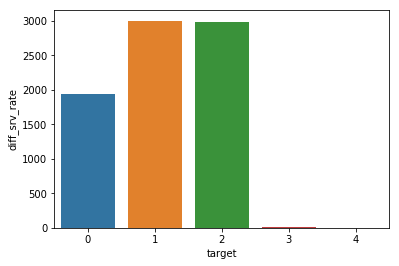

In [330]:
sns.barplot(data=d1, x='target',y='diff_srv_rate')
plt.show()

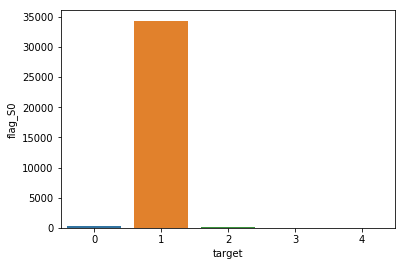

In [331]:
sns.barplot(data=d2, x='target',y='flag_S0')
plt.show()

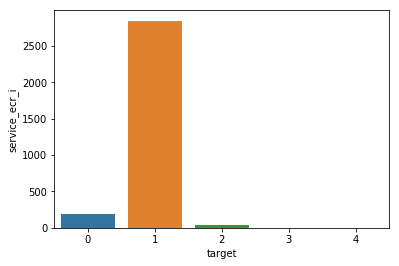

In [332]:
sns.barplot(data=d3, x='target',y='service_ecr_i')
plt.show()

#### 2. KNN

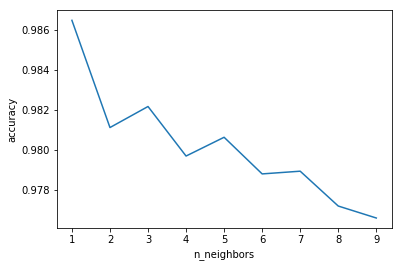

In [173]:
n_neighbors = list(range(1,10))
accuracy = []

for i in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors= i)
    acc = cross_val_score(knn, train_X, train_y, scoring='accuracy')
    accuracy.append(np.mean(acc))
    
plt.plot(n_neighbors,accuracy)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.show()

In [175]:
knn = KNeighborsClassifier()
knn.fit(train_X, train_y)
train_predicted = knn.predict(train_X)
test_predicted = knn.predict(test_X)

metrics.confusion_matrix(y_pred=test_predicted,y_true=test_y)

array([[19987,    61,    64,    50,     0],
       [  122, 13656,    73,    10,     0],
       [   63,   104,  3271,    24,     0],
       [   89,    12,    25,   169,     0],
       [    2,     0,     1,     4,     5]], dtype=int64)

In [176]:
train_accuracy = metrics.accuracy_score(y_true=train['target'], y_pred=train_predicted)
test_accuracy = metrics.accuracy_score(y_true=test['target'], y_pred=test_predicted)

print("The Accuracy for the model built on the Train Data is : ", train_accuracy)
print("The Accuracy for the model built on the Test Data is : ", test_accuracy)

train_precision = metrics.precision_score(y_true=train['target'], y_pred=train_predicted,average='weighted')
test_precision = metrics.precision_score(y_true=test['target'], y_pred=test_predicted,average='weighted')

print("The Precision for the model built on the Train Data is : ", train_precision)
print("The Precision for the model built on the Test Data is : ", test_precision)

train_f1 = metrics.f1_score(y_true=train['target'], y_pred=train_predicted,average='weighted')
test_f1 = metrics.f1_score(y_true=test['target'], y_pred=test_predicted,average='weighted')

print("The Recall for the model built on the Train Data is : ", train_f1)
print("The Recall for the model built on the Test Data is : ", test_f1)

The Accuracy for the model built on the Train Data is :  0.9884442226783547
The Accuracy for the model built on the Test Data is :  0.9813717188823031
The Precision for the model built on the Train Data is :  0.9882577072219401
The Precision for the model built on the Test Data is :  0.9810191760229158
The Recall for the model built on the Train Data is :  0.9882950856889344
The Recall for the model built on the Test Data is :  0.9811294584818413


#### 3. Decision Tree

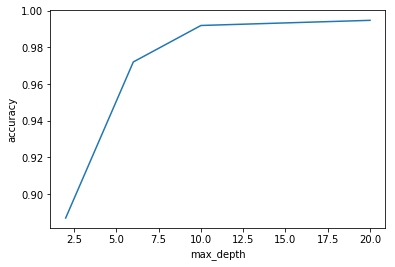

In [185]:
max_depth = [2,6,10,20]
accuracy = []

for i in max_depth:
    dt = DT(max_depth= i,random_state=123)
    acc = cross_val_score(dt, train_X, train_y, scoring='accuracy')
    accuracy.append(np.mean(acc))
    
plt.plot(max_depth,accuracy)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

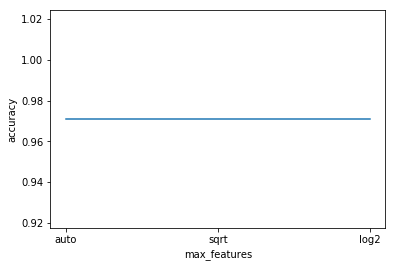

In [186]:
max_features = ['auto','sqrt','log2']
accuracy = []

for i in max_features:
    dt = DT(max_features= i,random_state=123,max_depth=10)
    acc = cross_val_score(dt, train_X, train_y, scoring='accuracy')
    accuracy.append(np.mean(acc))
    
plt.plot(max_features,accuracy)
plt.xlabel('max_features')
plt.ylabel('accuracy')
plt.show()

In [188]:
dt = DT(max_depth=10)
dt.fit(train_X, train_y)
train_predicted = dt.predict(train_X)
test_predicted = dt.predict(test_X)

metrics.confusion_matrix(y_pred=test_predicted,y_true=test_y)

array([[20009,    46,    32,    75,     0],
       [   21, 13801,    26,    13,     0],
       [   26,    21,  3405,    10,     0],
       [   19,     0,     1,   275,     0],
       [    5,     0,     0,     7,     0]], dtype=int64)

In [189]:
train_accuracy = metrics.accuracy_score(y_true=train['target'], y_pred=train_predicted)
test_accuracy = metrics.accuracy_score(y_true=test['target'], y_pred=test_predicted)

print("The Accuracy for the model built on the Train Data is : ", train_accuracy)
print("The Accuracy for the model built on the Test Data is : ", test_accuracy)

train_precision = metrics.precision_score(y_true=train['target'], y_pred=train_predicted,average='weighted')
test_precision = metrics.precision_score(y_true=test['target'], y_pred=test_predicted,average='weighted')

print("The Precision for the model built on the Train Data is : ", train_precision)
print("The Precision for the model built on the Test Data is : ", test_precision)

train_f1 = metrics.f1_score(y_true=train['target'], y_pred=train_predicted,average='weighted')
test_f1 = metrics.f1_score(y_true=test['target'], y_pred=test_predicted,average='weighted')

print("The Recall for the model built on the Train Data is : ", train_f1)
print("The Recall for the model built on the Test Data is : ", test_f1)

The Accuracy for the model built on the Train Data is :  0.993717467481657
The Accuracy for the model built on the Test Data is :  0.9920088907705334
The Precision for the model built on the Train Data is :  0.9943125240202161
The Precision for the model built on the Test Data is :  0.992306964050458
The Recall for the model built on the Train Data is :  0.9937359454847484
The Recall for the model built on the Test Data is :  0.9920532104606767


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [190]:
feature_map = [(i, v) for i, v in itertools.zip_longest(train_X.columns, dt.feature_importances_)]
Feature_importance = pd.DataFrame(feature_map, columns=['Feature', 'importance'])
Feature_importance.sort_values('importance', inplace=True, ascending=False)
Feature_importance

Feature  importance
0            diff_srv_rate    0.591870
5                last_flag    0.147279
10           service_ecr_i    0.068775
7              rerror_rate    0.055748
2   dst_host_diff_srv_rate    0.041364
9            service_eco_i    0.028148
12         service_private    0.020622
3                  flag_S0    0.020542
1           dst_host_count    0.014378
11            service_http    0.008153
6          num_compromised    0.002613
4                  flag_S1    0.000383
8             root_shell_1    0.000125